# CAR PRICE PREDICTION - LINEAR REGRESSION

# Car Price Prediction Using Linear Regression

This notebook predicts car prices using **Linear Regression**.

The dataset used is from the **Cars4U Project**, a popular dataset among data scientists for practicing machine learning techniques.

---

### 🔧 Key Customizations in My Version

1. **Smart Missing Value Imputation**  
   Missing values were imputed based on the `Name` column, which includes detailed information such as **Brand**, **Model**, **Fuel Type**, **Engine Size**, and **Package**.  
   - If an exact match in the `Name` column was found, that was used to impute missing values.  
   - If not, a fallback imputation based on **Brand-Model** combinations was applied.

2. **Log Transformation of Skewed Features**  
   The target variable `Price` and two negatively skewed features — `Kilometers_Driven` and `Power` — were log-transformed to normalize their distributions.  
   - These transformations were handled **within the pipeline**.

3. **Model Performance: Ridge Regression**  
   - The **Ridge Regression** model yielded the best performance.  
   - Achieved an **R² score of 0.90** on the test set.  
   - Reported a **Mean Absolute Percentage Error (MAPE)** of **0.16**, indicating strong prediction accuracy.  
   - There was **no evidence of overfitting or high bias**.

---

**Feature Description**
- S.No - Serial Number
- Name - Name of the car (Brand name and Model name included)
- Location - Location in which the car is being sold/available
- Year - Manufacturing year of the car
- Kilometers_driven - Total KMs driven by the previous owner in KM
- Fuel_Type - Fuel type of the car (Petrol/Diesel/Electric/CNG/LPG)
- Transmission - Transmission type of the car (Automatic/Manual)
- Owner - Type of ownership
- Mileage - Standard mileage offered by the car company in kmpl or km/kg
- Engine - The displacement volume of the engine in CC
- Power - The maximum power of the engine in bhp
- Seats - The number of seats in the car
- New_Price - The price of a new car of the same model in INR Lakhs
- Price - The price of the used car in INR Lakhs

In [1]:
import pandas as pd      
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split


from scipy.stats import skew

from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (7,4)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

In [2]:
df = pd.read_csv("used_cars_data.csv")

In [3]:
df.head()

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
df.shape
# 14 columns and 7253 observations

(7253, 14)

In [5]:
df.isnull().sum().sort_values(ascending=False) # checking number of null values

New_Price            6247
Price                1234
Seats                  53
Engine                 46
Power                  46
Mileage                 2
Fuel_Type               0
Kilometers_Driven       0
Year                    0
Location                0
Name                    0
S.No.                   0
Transmission            0
Owner_Type              0
dtype: int64

- drop New_Price altogether due to high number of missingness
- drop S.No. because it is not a feature per se
- drop null values in Price (target feature)
- try and impute null values in Seats, Engine, and Power based on Vehicle Name
- impute mileage using Name if brand-model is avaialble in the data

In [6]:
df.dtypes # checking datatypes

S.No.                  int64
Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object

In [7]:
df.info() # checking datatypes and number of non-null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              7253 non-null   int64  
 1   Name               7253 non-null   object 
 2   Location           7253 non-null   object 
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 793.4+ KB


In [8]:
df.duplicated().sum() # checking for duplicates

np.int64(0)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
S.No.,7253.0,3626.000000,2093.905084,0.00,1813.0,3626.00,5439.00,7252.0
Year,7253.0,2013.365366,3.254421,1996.00,2011.0,2014.00,2016.00,2019.0
Kilometers_Driven,7253.0,58699.063146,84427.720583,171.00,34000.0,53416.00,73000.00,6500000.0
Seats,7200.0,5.279722,0.811660,0.00,5.0,5.00,5.00,10.0
Price,6019.0,9.479468,11.187917,0.44,3.5,5.64,9.95,160.0


## Data Preprocessing

In [10]:
# Let's drop features that are NOT needed
df.drop(columns = ["S.No.", "New_Price"], inplace = True)

In [11]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [12]:
df.nunique()

Name                 2041
Location               11
Year                   23
Kilometers_Driven    3660
Fuel_Type               5
Transmission            2
Owner_Type              4
Mileage               450
Engine                150
Power                 386
Seats                   9
Price                1373
dtype: int64

### Brand

In [13]:
# Let's create Brand from Name column
df['Brand'] = df['Name'].str.split().str[0]
df.Brand.value_counts()

Brand
Maruti           1444
Hyundai          1340
Honda             743
Toyota            507
Mercedes-Benz     380
Volkswagen        374
Ford              351
Mahindra          331
BMW               312
Audi              285
Tata              228
Skoda             202
Renault           170
Chevrolet         151
Nissan            117
Land               67
Jaguar             48
Fiat               38
Mitsubishi         36
Mini               31
Volvo              28
Jeep               19
Porsche            19
Datsun             17
Force               3
ISUZU               3
Isuzu               2
Bentley             2
Smart               1
Ambassador          1
Lamborghini         1
Hindustan           1
OpelCorsa           1
Name: count, dtype: int64

In [14]:
df['Brand_Model'] = df['Name'].str.split().str[:2].str.join(' ')
df['Brand_Model'].value_counts().sort_index()

Brand_Model
Ambassador Classic           1
Audi A3                      6
Audi A4                     90
Audi A6                     66
Audi A7                      3
Audi A8                      3
Audi Q3                     35
Audi Q5                     38
Audi Q7                     39
Audi RS5                     2
Audi TT                      3
BMW 1                        3
BMW 3                      109
BMW 5                       86
BMW 6                        9
BMW 7                       17
BMW X1                      36
BMW X3                      17
BMW X5                      25
BMW X6                       8
BMW Z4                       2
Bentley Continental          1
Bentley Flying               1
Chevrolet Aveo              17
Chevrolet Beat              54
Chevrolet Captiva            3
Chevrolet Cruze             23
Chevrolet Enjoy             13
Chevrolet Optra             13
Chevrolet Sail              10
Chevrolet Spark             15
Chevrolet Tavera           

In [15]:
# Drop Brand_Model
df.drop(["Brand_Model"], axis=1, inplace=True)
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75,Maruti
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50,Hyundai
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50,Honda
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00,Maruti
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74,Audi


In [16]:
df["Brand"].unique()
# need to make a few corrections

array(['Maruti', 'Hyundai', 'Honda', 'Audi', 'Nissan', 'Toyota',
       'Volkswagen', 'Tata', 'Land', 'Mitsubishi', 'Renault',
       'Mercedes-Benz', 'BMW', 'Mahindra', 'Ford', 'Porsche', 'Datsun',
       'Jaguar', 'Volvo', 'Chevrolet', 'Skoda', 'Mini', 'Fiat', 'Jeep',
       'Smart', 'Ambassador', 'Isuzu', 'ISUZU', 'Force', 'Bentley',
       'Lamborghini', 'Hindustan', 'OpelCorsa'], dtype=object)

In [17]:
df.loc[df["Brand"]=="Mini","Brand"]="Mini Cooper"
df.loc[df["Brand"]=="ISUZU","Brand"]="Isuzu"
df.loc[df["Brand"]=="OpelCorsa", "Brand"]="Opel"
df["Brand"].unique()

array(['Maruti', 'Hyundai', 'Honda', 'Audi', 'Nissan', 'Toyota',
       'Volkswagen', 'Tata', 'Land', 'Mitsubishi', 'Renault',
       'Mercedes-Benz', 'BMW', 'Mahindra', 'Ford', 'Porsche', 'Datsun',
       'Jaguar', 'Volvo', 'Chevrolet', 'Skoda', 'Mini Cooper', 'Fiat',
       'Jeep', 'Smart', 'Ambassador', 'Isuzu', 'Force', 'Bentley',
       'Lamborghini', 'Hindustan', 'Opel'], dtype=object)

In [18]:
def countplot_with_labels(df, column, top_n=None, figsize=(10, 5), palette='viridis', rotation=45):
    """
    Create a seaborn countplot with count labels.

    Parameters:
    - df: pandas DataFrame
    - column: column name to count
    - top_n: show only top N most frequent values (optional)
    - figsize: tuple for figure size
    - palette: seaborn color palette
    - rotation: rotation angle for x-axis labels
    """
    value_counts = df[column].value_counts()

    if top_n:
        value_counts = value_counts.head(top_n)

    plt.figure(figsize=figsize)
    ax = sns.countplot(data=df[df[column].isin(value_counts.index)], 
                       x=column, 
                       order=value_counts.index, 
                       palette=palette)

    # Add count labels on top of bars
    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(f'{count}', 
                    (p.get_x() + p.get_width() / 2., count), 
                    ha='center', va='bottom')

    plt.title(f'Countplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

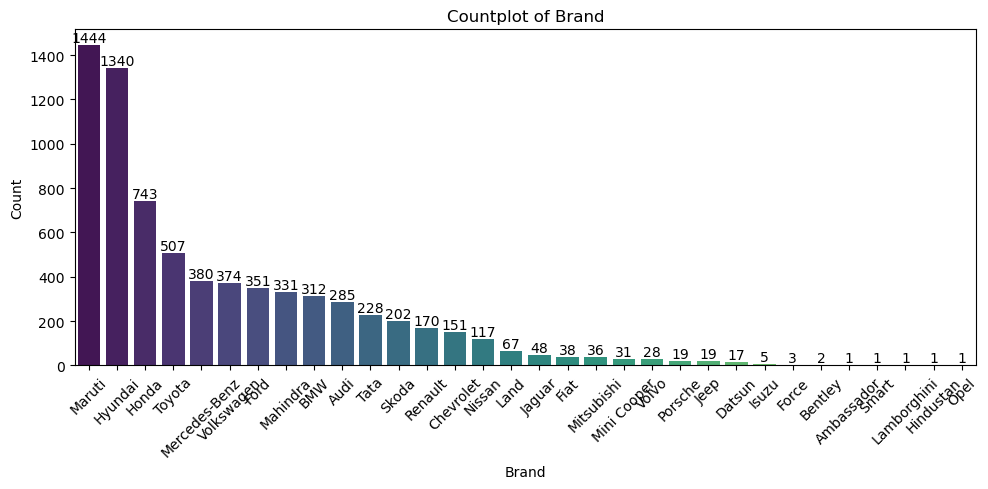

In [19]:
countplot_with_labels(df, column='Brand')

### Location

In [20]:
df.Location.value_counts()

Location
Mumbai        949
Hyderabad     876
Coimbatore    772
Kochi         772
Pune          765
Delhi         660
Kolkata       654
Chennai       591
Jaipur        499
Bangalore     440
Ahmedabad     275
Name: count, dtype: int64

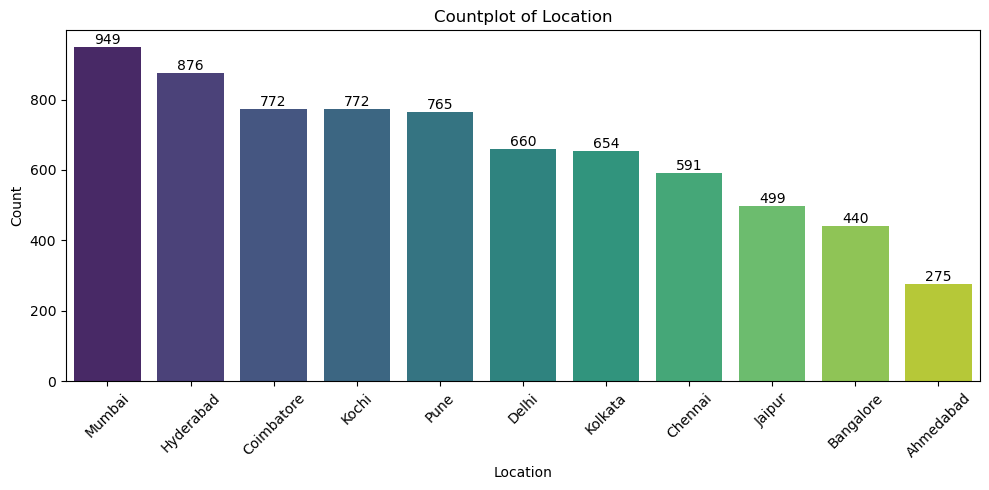

In [21]:
countplot_with_labels(df, "Location")

### Fuel_Type

In [22]:
df.Fuel_Type.value_counts()

Fuel_Type
Diesel      3852
Petrol      3325
CNG           62
LPG           12
Electric       2
Name: count, dtype: int64

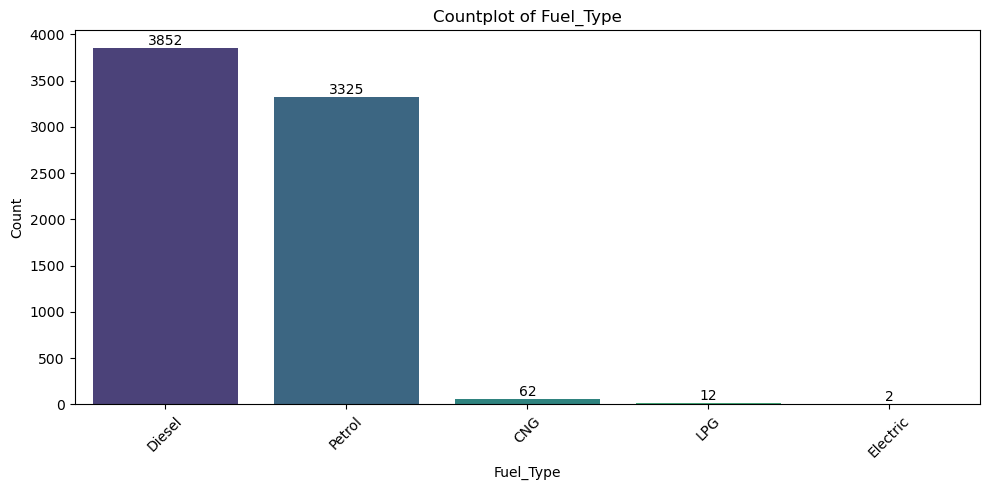

In [23]:
countplot_with_labels(df,"Fuel_Type")

### Tranmission

In [24]:
df.Transmission.value_counts()

Transmission
Manual       5204
Automatic    2049
Name: count, dtype: int64

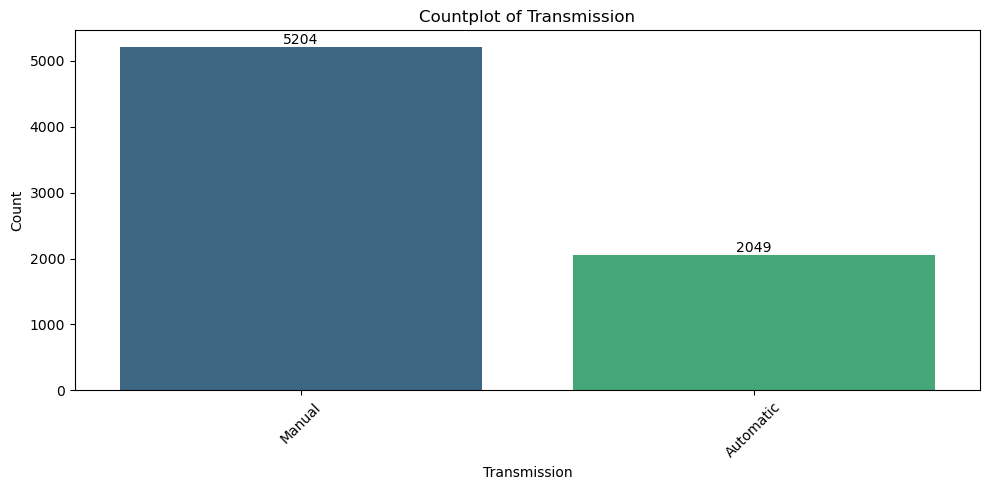

In [25]:
countplot_with_labels(df,'Transmission')

### Owner_Type

In [26]:
df.Owner_Type.value_counts()

Owner_Type
First             5952
Second            1152
Third              137
Fourth & Above      12
Name: count, dtype: int64

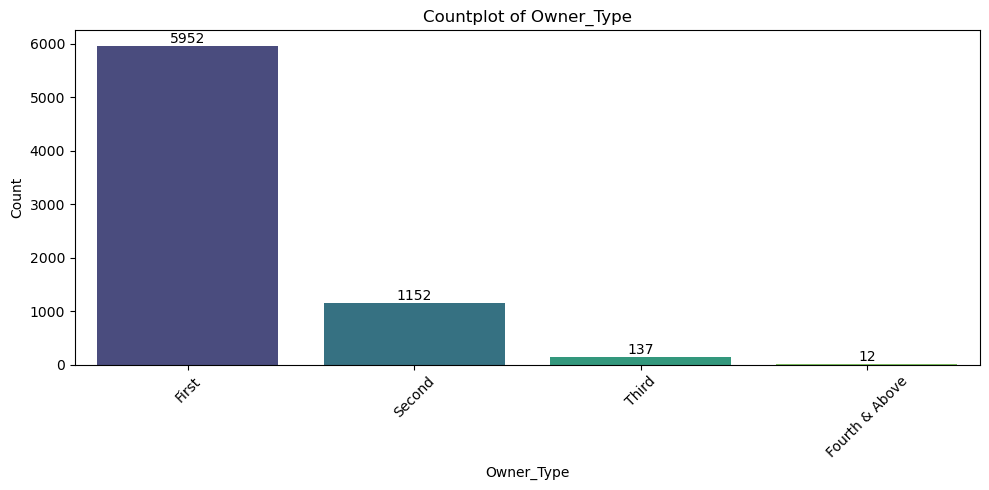

In [27]:
countplot_with_labels(df, 'Owner_Type')

In [28]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75,Maruti
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50,Hyundai
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50,Honda
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00,Maruti
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74,Audi


### Seats

In [29]:
df.Seats.value_counts()

Seats
5.0     6047
7.0      796
8.0      170
4.0      119
6.0       38
2.0       18
10.0       8
9.0        3
0.0        1
Name: count, dtype: int64

In [30]:
df.loc[df.Seats==0.0, ["Name", "Power", "Engine"]]

# The vehicle with 0 seats is an Audi A4

,Name,Power,Engine
3999,Audi A4 3.2 FSI Tiptronic Quattro,null bhp,3197 CC


In [31]:
df.loc[df["Name"].str.contains("Audi A4"),["Name","Seats"]]

# It appears all Audi A4 cars have 5 seats
# I will recode 0.0 as 5.0

,Name,Seats
4,Audi A4 New 2.0 TDI Multitronic,5.0
50,Audi A4 2.0 TDI 177 Bhp Premium Plus,5.0
65,Audi A4 2.0 TDI Multitronic,5.0
103,Audi A4 3.0 TDI Quattro Premium,5.0
150,Audi A4 2.0 TDI 177 Bhp Premium Plus,5.0
717,Audi A4 2.0 TDI 177 Bhp Premium Plus,5.0
853,Audi A4 2.0 TDI,5.0
854,Audi A4 2.0 TDI,5.0
874,Audi A4 2.0 TDI Multitronic,5.0
964,Audi A4 2.0 TDI,5.0


In [32]:
df.loc[df["Seats"]==0.0, 'Seats']=5.0

In [33]:
df["Seats"].value_counts()

Seats
5.0     6048
7.0      796
8.0      170
4.0      119
6.0       38
2.0       18
10.0       8
9.0        3
Name: count, dtype: int64

### Numerical Features

In [34]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75,Maruti
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50,Hyundai
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50,Honda
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00,Maruti
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74,Audi


### Year

In [35]:
# The data were collected in 2020
df['Year'].value_counts().sort_index(ascending=False)

Year
2019    119
2018    361
2017    709
2016    886
2015    929
2014    925
2013    791
2012    690
2011    579
2010    407
2009    252
2008    207
2007    148
2006     89
2005     68
2004     35
2003     20
2002     18
2001      8
2000      5
1999      2
1998      4
1996      1
Name: count, dtype: int64

In [36]:
df['Age'] = 2020 - df['Year']

### Mileage

In [37]:
df.Mileage.value_counts()

Mileage
17.0 kmpl      207
18.9 kmpl      201
18.6 kmpl      144
21.1 kmpl      106
20.36 kmpl     105
17.8 kmpl       98
18.0 kmpl       89
12.8 kmpl       87
18.5 kmpl       86
16.0 kmpl       85
20.0 kmpl       82
0.0 kmpl        81
13.0 kmpl       79
22.7 kmpl       79
15.1 kmpl       78
12.99 kmpl      77
16.8 kmpl       69
16.47 kmpl      66
19.7 kmpl       64
25.8 kmpl       60
23.1 kmpl       58
22.32 kmpl      57
17.5 kmpl       56
13.5 kmpl       56
24.3 kmpl       55
19.4 kmpl       54
15.0 kmpl       52
11.5 kmpl       51
16.1 kmpl       51
17.01 kmpl      50
19.3 kmpl       50
22.9 kmpl       50
21.4 kmpl       49
19.0 kmpl       49
24.0 kmpl       47
22.07 kmpl      47
19.81 kmpl      46
19.01 kmpl      46
28.4 kmpl       45
19.67 kmpl      45
23.4 kmpl       45
19.1 kmpl       45
16.55 kmpl      44
12.55 kmpl      43
17.9 kmpl       43
21.9 kmpl       43
23.59 kmpl      43
14.0 kmpl       42
12.05 kmpl      41
17.68 kmpl      40
26.0 kmpl       40
26.59 kmpl      40
20.5

#### Converting km/kg to kmpl
https://www.autogasitalia.it/en/faq/metano/how-much-range-do-you-get-with-an-autogas-cng-conversion/

1kg CNG is equivalent to about 1 lt Petrol

In [38]:
# let's create a function to remove units and convert km/kg to kmpl

def mil(val):
    if isinstance(val,str):
            if val.endswith("km/kg"):
                return float(val.replace("km/kg",""))/1.7
            elif val.endswith("kmpl"):
                return float(val.replace("kmpl", ""))
    else:
        return np.nan


In [39]:
df["Mileage_new"]=df.Mileage.apply(mil)

In [40]:
df.Mileage_new.describe()

count    7251.000000
mean       18.039251
std         4.502623
min         0.000000
25%        15.100000
50%        18.100000
75%        20.920000
max        28.400000
Name: Mileage_new, dtype: float64

In [41]:
df.loc[df.Mileage.str.endswith("km/kg", na=False), ["Mileage", "Mileage_new"]]


,Mileage,Mileage_new
0,26.6 km/kg,15.647059
5,21.1 km/kg,12.411765
127,26.6 km/kg,15.647059
328,26.3 km/kg,15.470588
440,15.1 km/kg,8.882353
839,26.83 km/kg,15.782353
893,13.2 km/kg,7.764706
936,26.2 km/kg,15.411765
987,17.3 km/kg,10.176471
1135,26.3 km/kg,15.470588


In [42]:
df.Mileage_new.isna().sum()

np.int64(2)

In [43]:
mileage_nan= df.loc[df["Mileage_new"].isnull(), ["Name", "Mileage", "Mileage_new"]]
mileage_nan_names = mileage_nan.Name
df.loc[df["Name"].isin(mileage_nan_names),'Name']
df[df['Name'].isin(mileage_nan_names)]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Age,Mileage_new
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,NaN,72 CC,41 bhp,5.0,13.00,Mahindra,4,NaN
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798 CC,73 bhp,5.0,12.75,Toyota,9,NaN


### Engine

In [44]:
df['Engine']= df['Engine'].str.replace(" CC","").astype(float)

In [45]:
df['Engine'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7253 entries, 0 to 7252
Series name: Engine
Non-Null Count  Dtype  
--------------  -----  
7207 non-null   float64
dtypes: float64(1)
memory usage: 56.8 KB


### Power

In [46]:
df["Power_new"]=df["Power"].str.extract(r"(\d+\.?\d*)").astype(float)

In [47]:
df["Power"].isna().sum()

np.int64(46)

In [48]:
df["Power_new"].isna().sum()

np.int64(175)

In [49]:
df.loc[df["Power_new"].isna(), ["Power", "Power_new"]]

,Power,Power_new
76,null bhp,NaN
79,null bhp,NaN
89,null bhp,NaN
120,null bhp,NaN
143,null bhp,NaN
194,NaN,NaN
208,NaN,NaN
227,null bhp,NaN
245,null bhp,NaN
262,null bhp,NaN


In [50]:
df.loc[df["Power"].isna(),["Power", "Engine"]]

,Power,Engine
194,NaN,NaN
208,NaN,NaN
733,NaN,NaN
749,NaN,NaN
1294,NaN,NaN
1327,NaN,NaN
1385,NaN,NaN
1460,NaN,NaN
2074,NaN,NaN
2096,NaN,NaN


### Price

In [51]:
df.Price.describe()

count    6019.000000
mean        9.479468
std        11.187917
min         0.440000
25%         3.500000
50%         5.640000
75%         9.950000
max       160.000000
Name: Price, dtype: float64

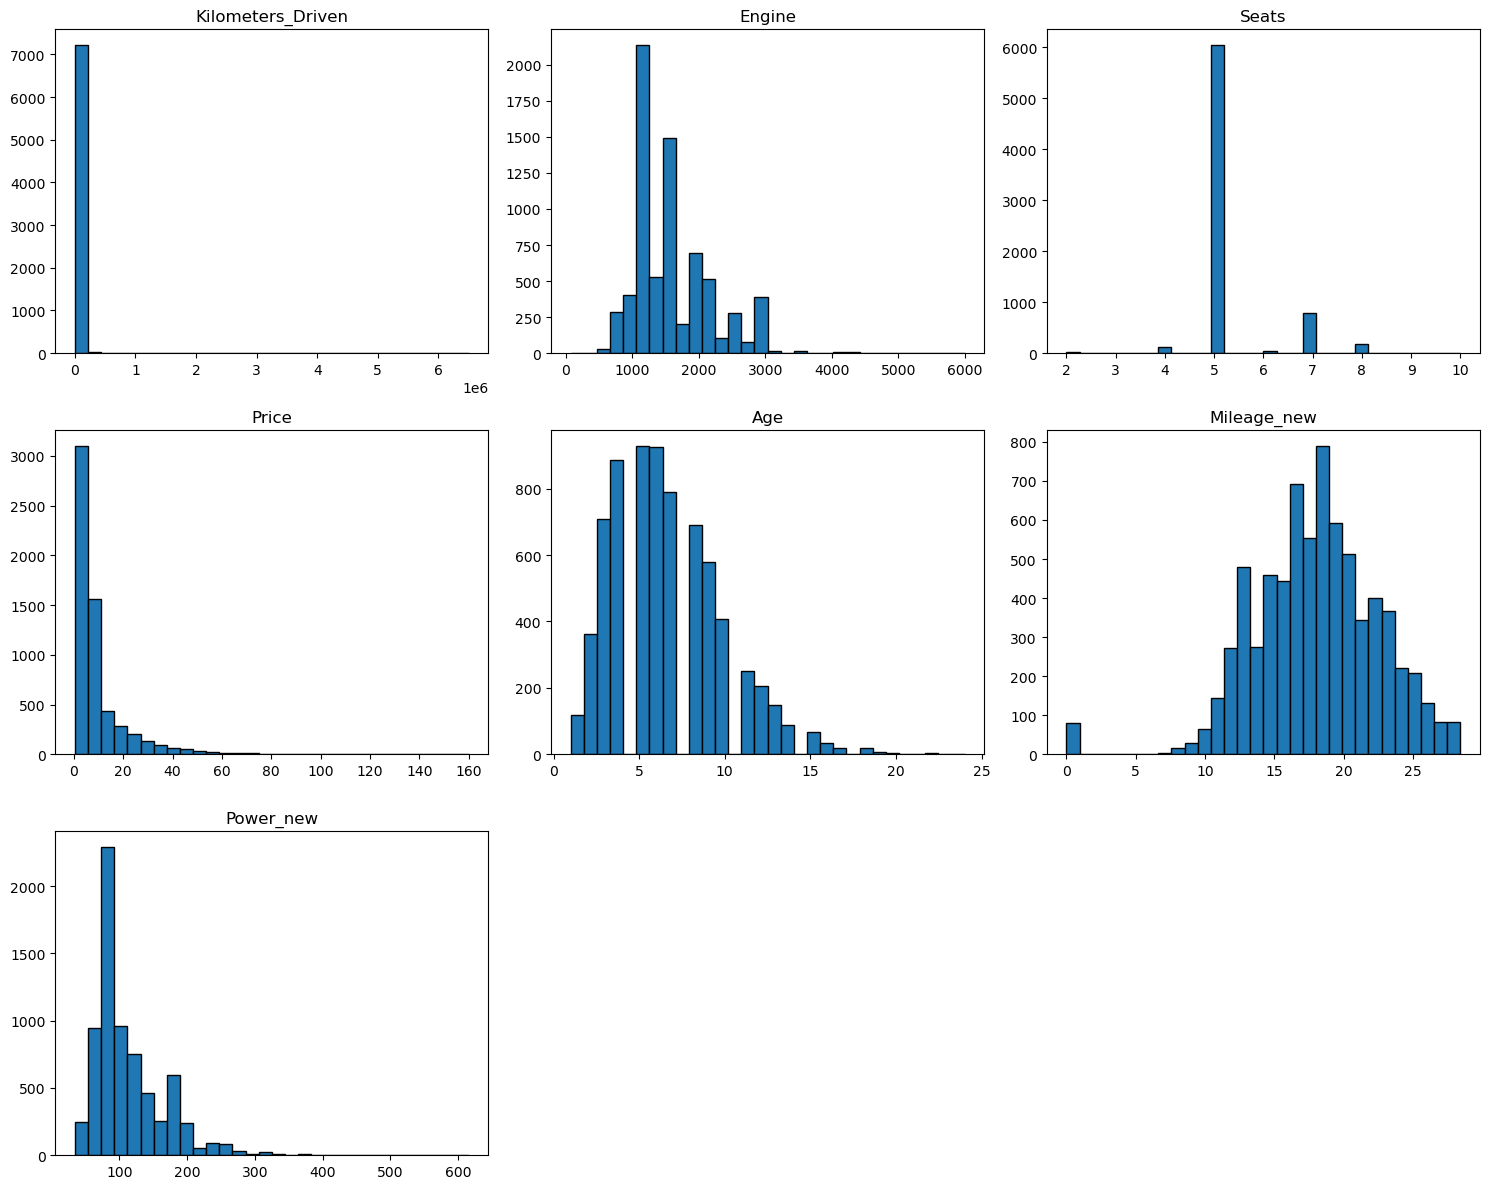

In [52]:
# let's pass numeric column names to a list and define a loop to create histograms

import math
num_col = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_col.remove("Year")
n = len(num_col)

cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for i in range(n):
    plt.subplot(rows, cols, i + 1)
    plt.hist(df[num_col[i]].dropna(), bins=30, edgecolor='black')
    plt.title(num_col[i])

plt.tight_layout()
plt.show()

## Bivariate Analysis

In [53]:
df.columns

Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'Price', 'Brand', 'Age', 'Mileage_new', 'Power_new'],
      dtype='object')

In [54]:
cat_features=["Location", "Fuel_Type", "Transmission", "Owner_Type", "Seats"]
target = "Price"

def visualize_categorical_vs_target(df, cat_features, target):
    """
    Visualizes the relationship between categorical features and a target variable.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    cat_features (list): List of categorical feature column names.
    target (str): The target variable name.
    """
    for cat_col in cat_features:
        plt.figure(figsize=(12, 6))

        # Check if target is categorical or has low cardinality
        if df[target].dtype == 'object' or df[target].nunique() < 10:
            ax = sns.countplot(data=df, x=cat_col, hue=target)
            plt.title(f'{cat_col} vs {target} (countplot)')

            # Add count labels on top of bars
            for p in ax.patches:
                height = p.get_height()
                if height > 0:
                    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                                ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5),
                                textcoords='offset points')
        else:
            ax = sns.barplot(data=df, x=cat_col, y=target, ci=None)
            plt.title(f'{cat_col} vs Average of {target}')

            # Add average labels on top of bars
            for p in ax.patches:
                height = p.get_height()
                if not pd.isna(height):
                    ax.annotate(f'{height:.1f}', (p.get_x() + p.get_width() / 2., height),
                                ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5),
                                textcoords='offset points')

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

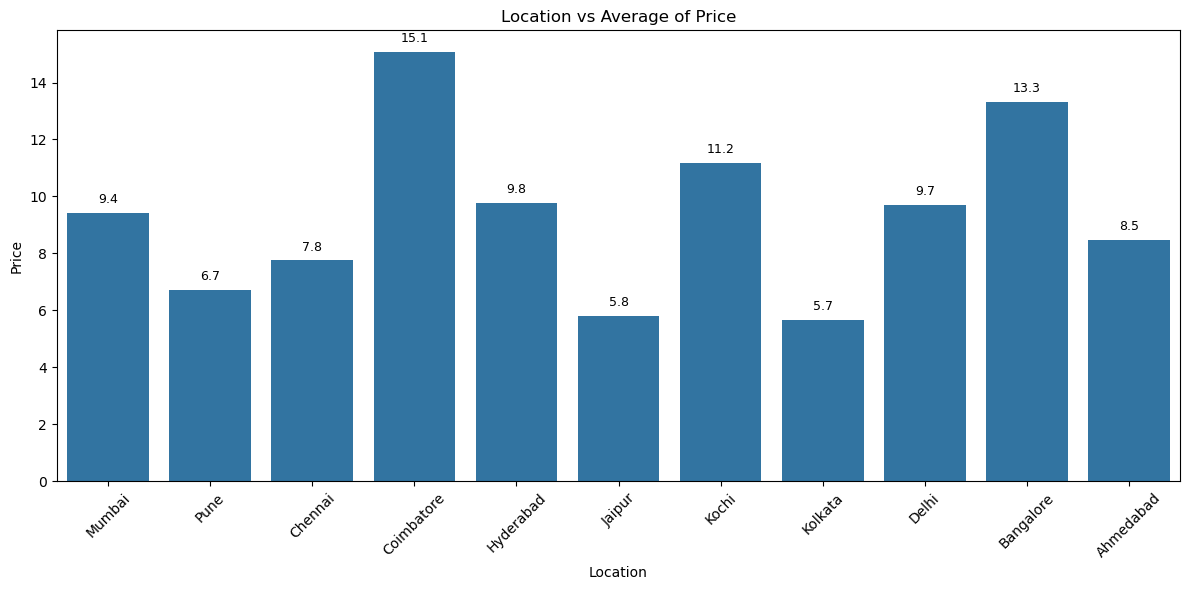

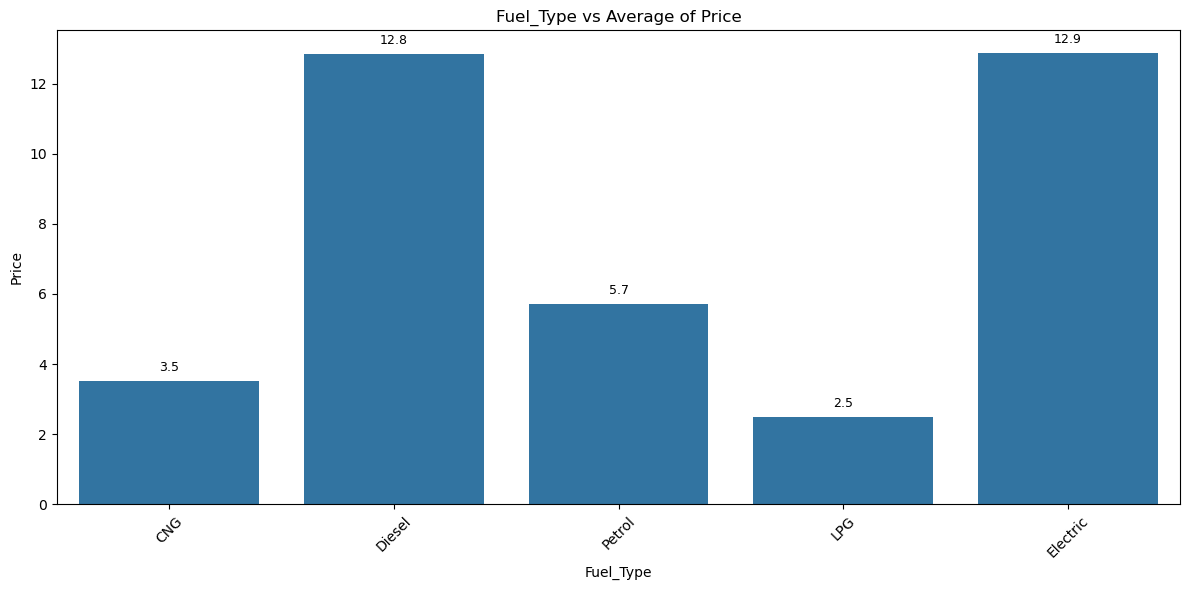

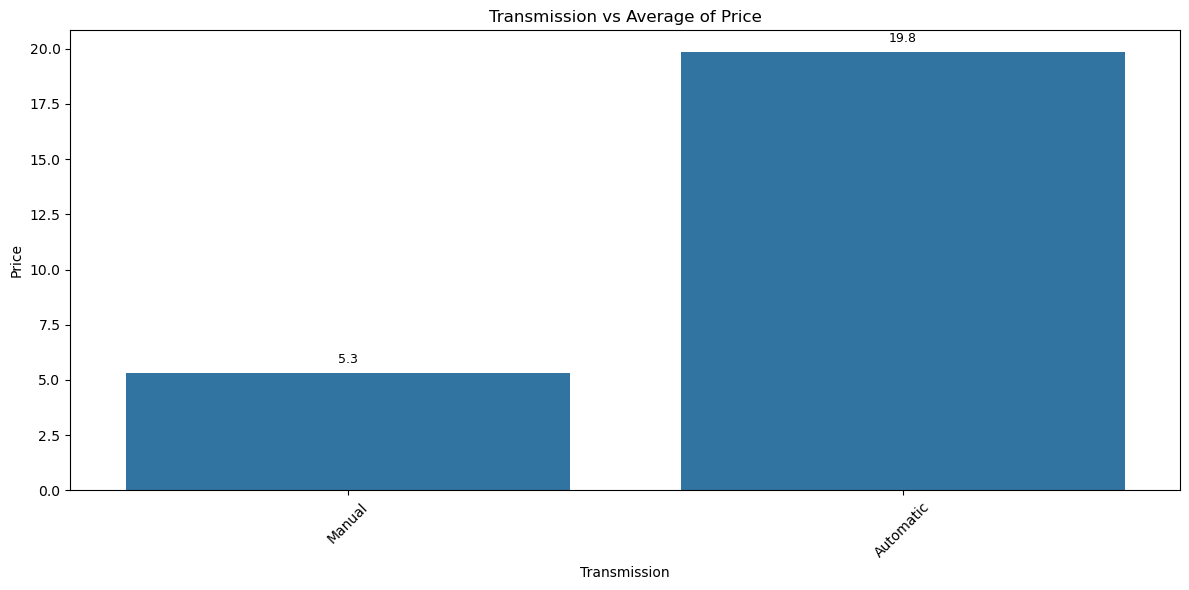

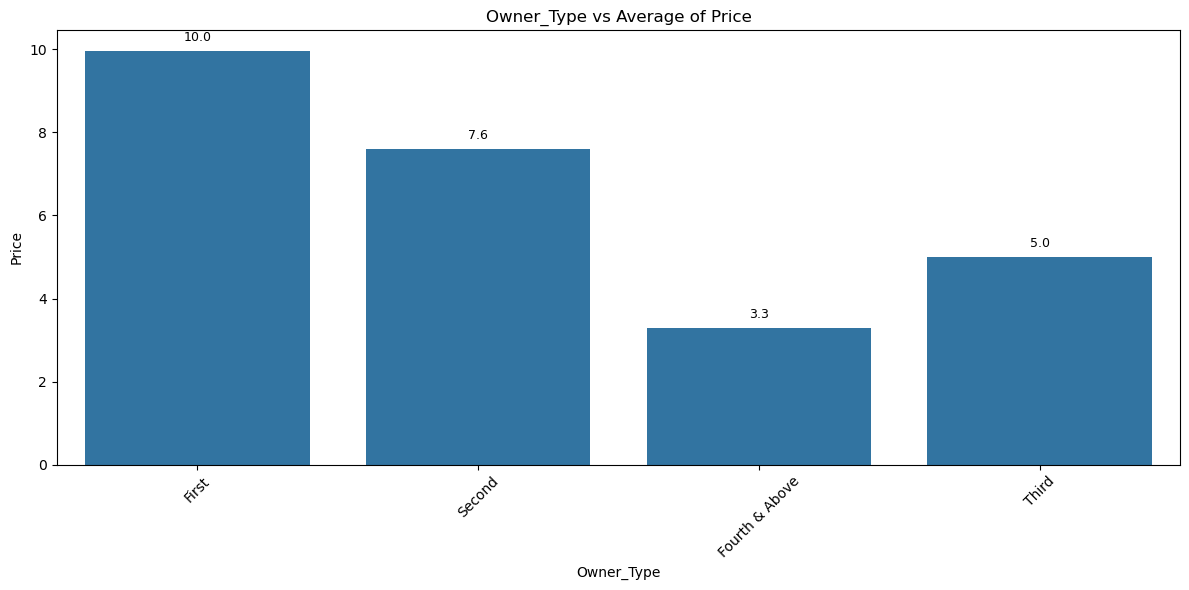

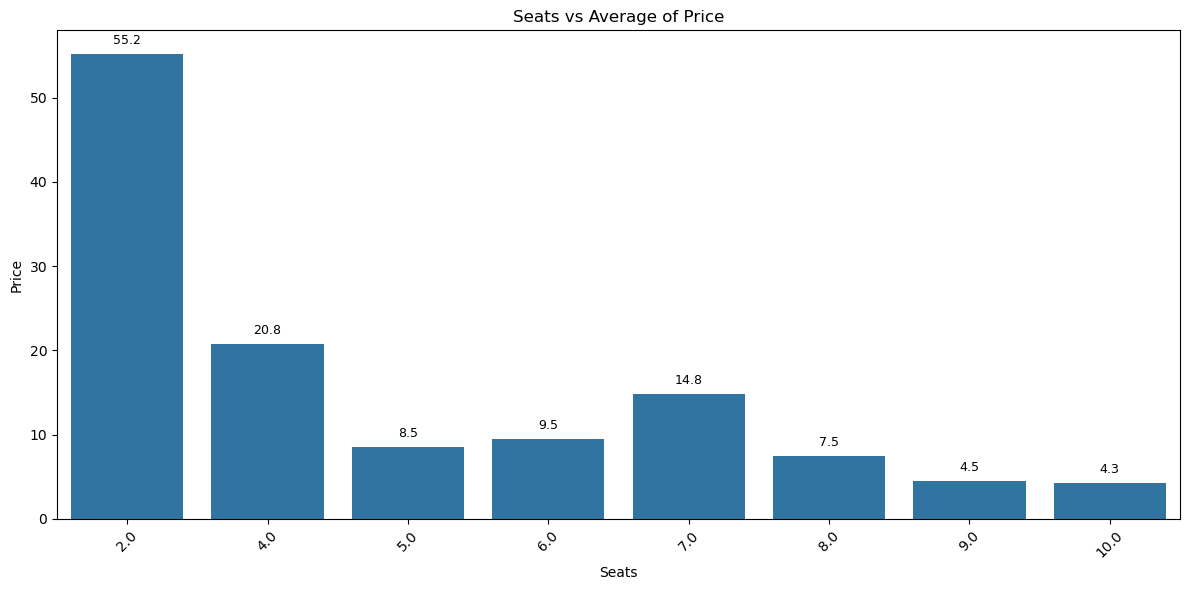

In [55]:
visualize_categorical_vs_target(df, cat_features, target)

In [56]:
def visualize_numerical_vs_target_with_corr(df, target):
    """
    Visualizes bivariate relationships between numerical features and the target variable:
    - Scatter plots with regression line
    - Correlation coefficients displayed
    - Correlation heatmap for all numerical features with the target

    Parameters:
    df (pd.DataFrame): The input DataFrame
    target (str): The name of the target variable
    """
    # Select only numerical columns and exclude target
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_features = [col for col in numerical_features if col != target]

    # Scatter plots with regression lines
    for col in numerical_features:
        plt.figure(figsize=(10, 6))
        sns.regplot(data=df, x=col, y=target, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        corr = df[[col, target]].dropna().corr().iloc[0, 1]
        plt.title(f'{col} vs {target}\nCorrelation: {corr:.2f}')
        plt.xlabel(col)
        plt.ylabel(target)
        plt.tight_layout()
        plt.show()

    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    corr_matrix = df[numerical_features + [target]].corr()
    sns.heatmap(corr_matrix[[target]].sort_values(by=target, ascending=False), 
                annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Correlation of Numerical Features with {target}')
    plt.tight_layout()
    plt.show()

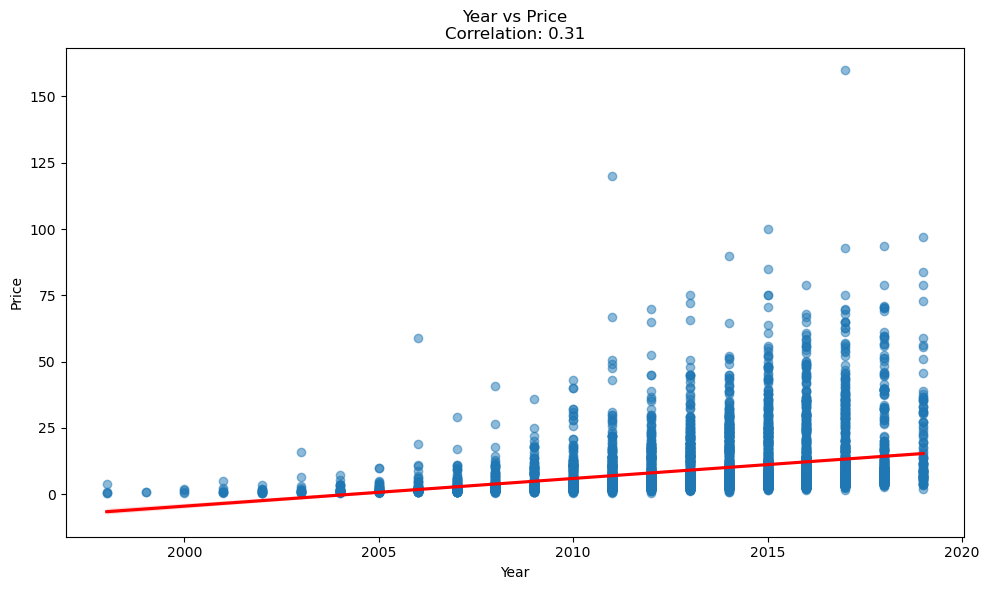

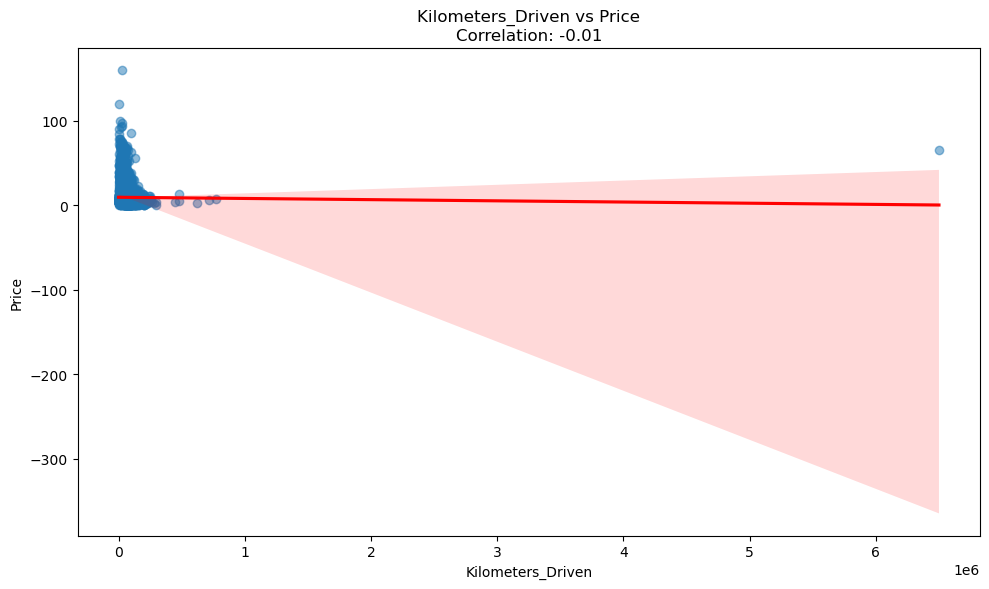

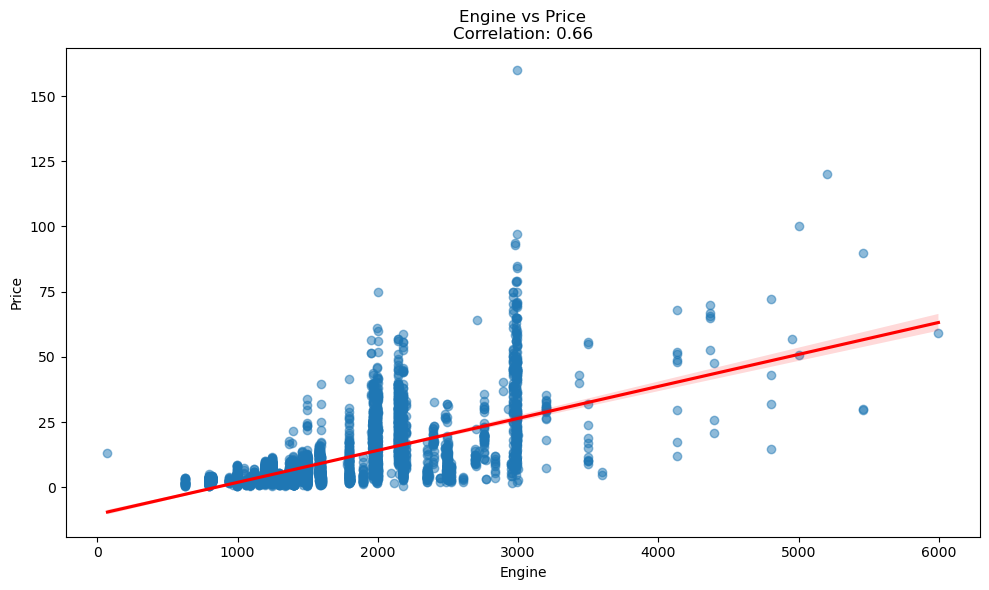

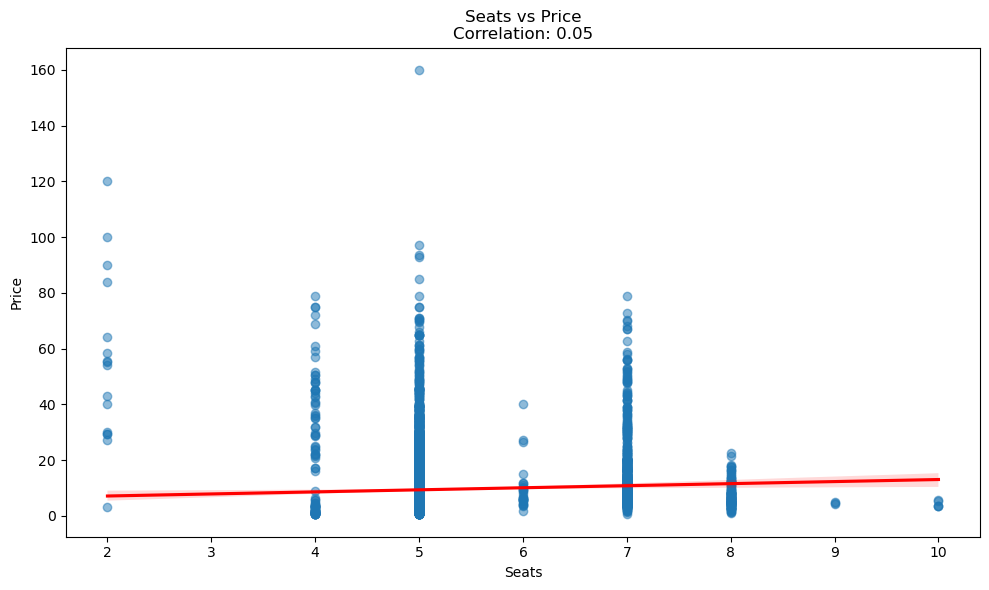

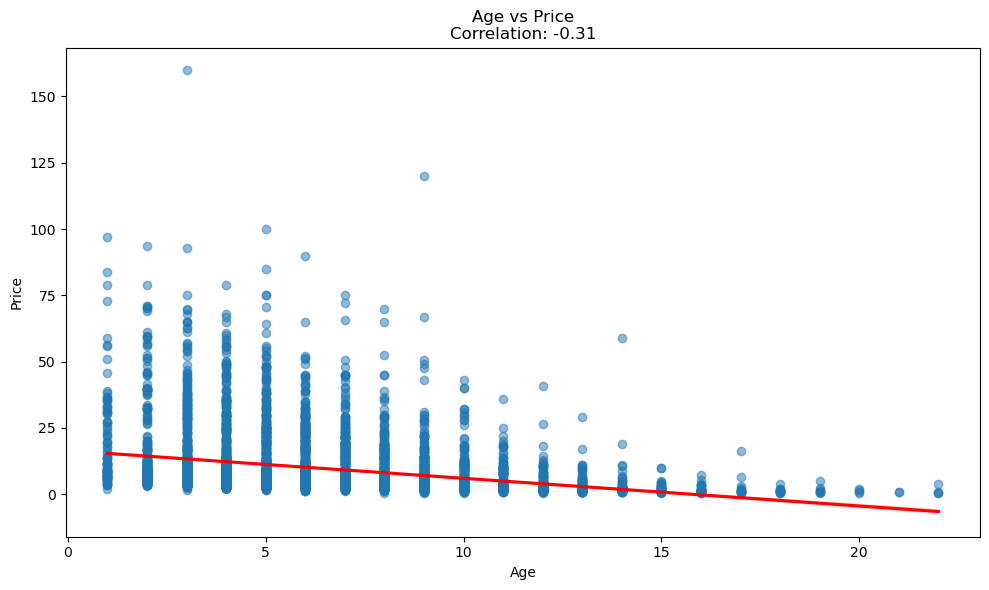

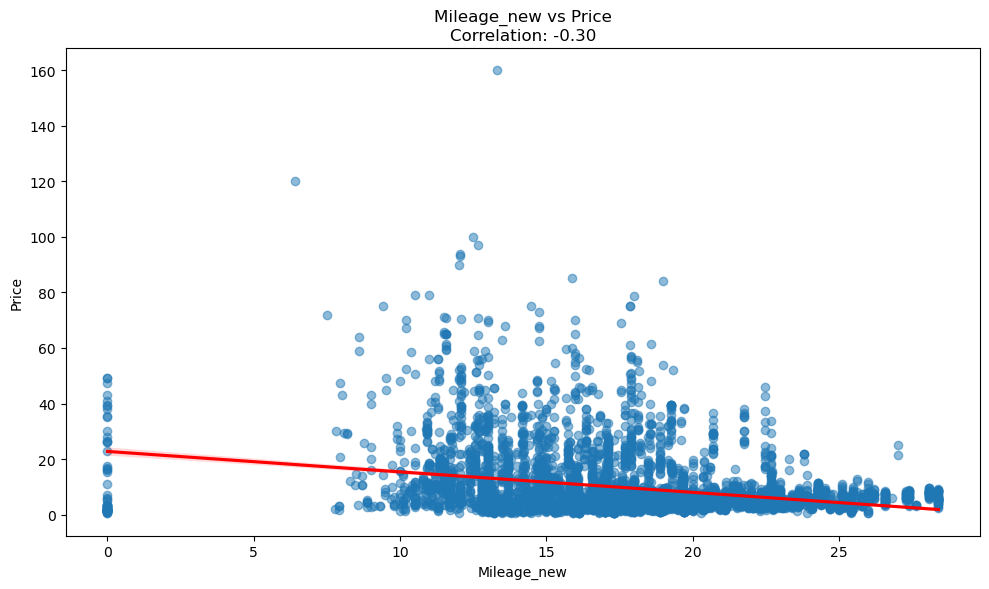

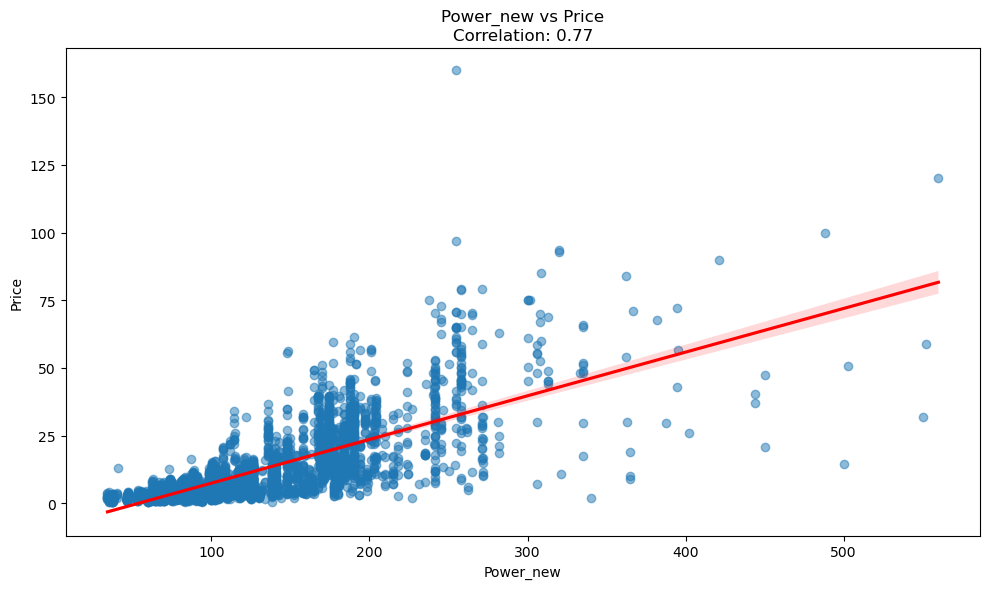

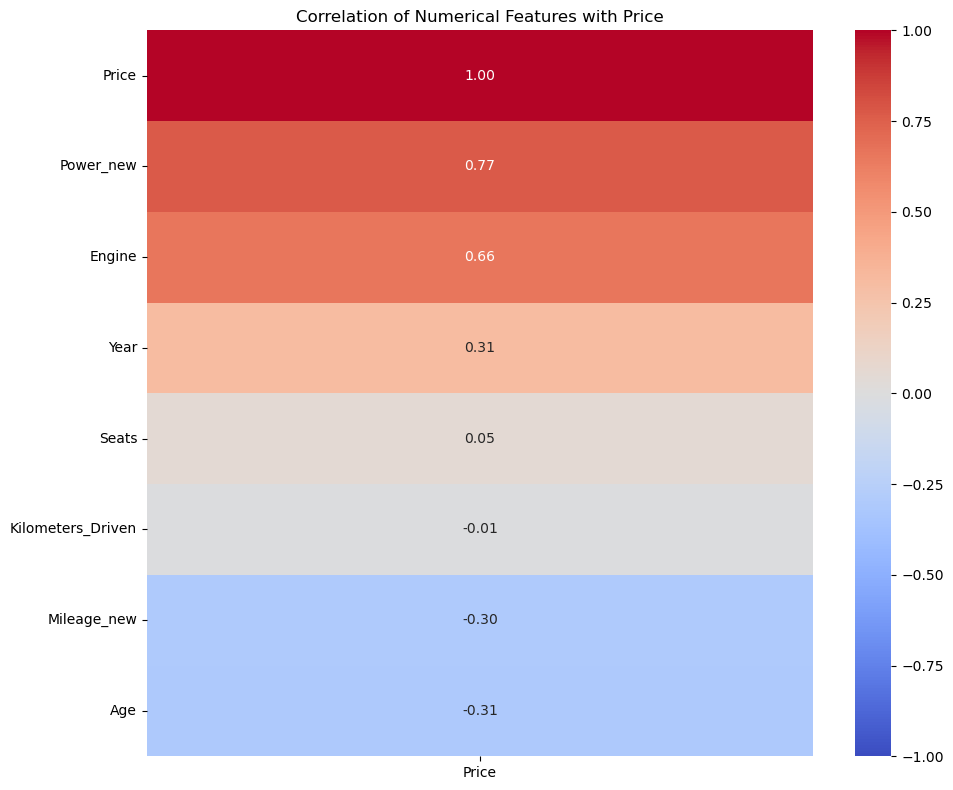

In [57]:
visualize_numerical_vs_target_with_corr(df, target)

## Missing Values



In [58]:
df.isna().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
Price                1234
Brand                   0
Age                     0
Mileage_new             2
Power_new             175
dtype: int64

In [59]:
# let's drop the original Power column
df.drop(columns=["Power"], inplace=True)

In [60]:
df.isna().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Seats                  53
Price                1234
Brand                   0
Age                     0
Mileage_new             2
Power_new             175
dtype: int64

In [61]:
df.isnull().sum(axis=1).value_counts()

0    5872
1    1306
3      36
2      29
4      10
Name: count, dtype: int64

In [62]:
num_missing_val=df.isnull().sum(axis=1)
num_missing_val.value_counts()

0    5872
1    1306
3      36
2      29
4      10
Name: count, dtype: int64

In [63]:
df[num_missing_val==4]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Price,Brand,Age,Mileage_new,Power_new
6042,Skoda Laura 1.8 TSI Ambition,Bangalore,2009,72000,Petrol,Manual,Second,17.5 kmpl,NaN,NaN,NaN,Skoda,11,17.50,NaN
6541,Toyota Etios Liva Diesel TRD Sportivo,Bangalore,2012,56600,Diesel,Manual,First,23.59 kmpl,NaN,NaN,NaN,Toyota,8,23.59,NaN
6544,Hyundai i20 new Sportz AT 1.4,Bangalore,2012,58000,Petrol,Automatic,Second,15.0 kmpl,NaN,NaN,NaN,Hyundai,8,15.00,NaN
6633,Mahindra TUV 300 P4,Kolkata,2016,27000,Diesel,Manual,First,0.0 kmpl,NaN,NaN,NaN,Mahindra,4,0.00,NaN
6643,BMW 5 Series 520d Sedan,Bangalore,2009,150000,Diesel,Automatic,Second,18.48 kmpl,NaN,NaN,NaN,BMW,11,18.48,NaN
6651,Maruti Swift 1.3 VXi,Kolkata,2015,36009,Petrol,Manual,First,16.1 kmpl,NaN,NaN,NaN,Maruti,5,16.10,NaN
6677,Fiat Punto 1.4 Emotion,Jaipur,2010,65000,Petrol,Manual,Third,14.6 kmpl,NaN,NaN,NaN,Fiat,10,14.60,NaN
6685,Maruti Swift 1.3 VXi,Pune,2010,115000,Petrol,Manual,Second,16.1 kmpl,NaN,NaN,NaN,Maruti,10,16.10,NaN
6880,BMW 5 Series 520d Sedan,Chennai,2009,95000,Diesel,Automatic,Second,18.48 kmpl,NaN,NaN,NaN,BMW,11,18.48,NaN
6902,Toyota Etios Liva V,Kochi,2012,59311,Petrol,Manual,First,18.3 kmpl,NaN,NaN,NaN,Toyota,8,18.30,NaN


In [64]:
df[num_missing_val==3]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Price,Brand,Age,Mileage_new,Power_new
194,Honda City 1.5 GXI,Ahmedabad,2007,60006,Petrol,Manual,First,0.0 kmpl,NaN,NaN,2.95,Honda,13,0.00,NaN
208,Maruti Swift 1.3 VXi,Kolkata,2010,42001,Petrol,Manual,First,16.1 kmpl,NaN,NaN,2.11,Maruti,10,16.10,NaN
733,Maruti Swift 1.3 VXi,Chennai,2006,97800,Petrol,Manual,Third,16.1 kmpl,NaN,NaN,1.75,Maruti,14,16.10,NaN
749,Land Rover Range Rover 3.0 D,Mumbai,2008,55001,Diesel,Automatic,Second,0.0 kmpl,NaN,NaN,26.50,Land,12,0.00,NaN
1294,Honda City 1.3 DX,Delhi,2009,55005,Petrol,Manual,First,12.8 kmpl,NaN,NaN,3.20,Honda,11,12.80,NaN
1327,Maruti Swift 1.3 ZXI,Hyderabad,2015,50295,Petrol,Manual,First,16.1 kmpl,NaN,NaN,5.80,Maruti,5,16.10,NaN
1385,Honda City 1.5 GXI,Pune,2004,115000,Petrol,Manual,Second,0.0 kmpl,NaN,NaN,1.50,Honda,16,0.00,NaN
1460,Land Rover Range Rover Sport 2005 2012 Sport,Coimbatore,2008,69078,Petrol,Manual,First,0.0 kmpl,NaN,NaN,40.88,Land,12,0.00,NaN
2074,Maruti Swift 1.3 LXI,Pune,2011,24255,Petrol,Manual,First,16.1 kmpl,NaN,NaN,3.15,Maruti,9,16.10,NaN
2096,Hyundai Santro LP zipPlus,Coimbatore,2004,52146,Petrol,Manual,First,0.0 kmpl,NaN,NaN,1.93,Hyundai,16,0.00,NaN


In [65]:
def fill_most_freq_by_name(df, col_name):
    """
    Fills missing (NaN) values in a specified column using:
    1. Exact match on the 'Name' column.
    2. If no match found, fallback to match using the first two words of the 'Name'.

    Parameters:
    df (pd.DataFrame): DataFrame to process.
    col_name (str): The column to impute.

    Returns:
    None (modifies df in place). Prints stats after imputation.
    """
    missing_idx = df[df[col_name].isna()].index

    for idx in missing_idx:
        name = df.at[idx, "Name"]

        # Step 1: Exact match on Name
        exact_matches = df[(df["Name"] == name) & df[col_name].notna()]

        if not exact_matches.empty:
            mode_val = exact_matches[col_name].mode().iloc[0]
            df.at[idx, col_name] = mode_val
            continue

        # Step 2: First two words match
        prefix = " ".join(name.split()[:2])
        prefix_matches = df[
            df["Name"].str.startswith(prefix) & df[col_name].notna()
        ]

        if not prefix_matches.empty:
            mode_val = prefix_matches[col_name].mode().iloc[0]
            df.at[idx, col_name] = mode_val

    # Print summary
    print("COLUMN NAME    : ", col_name)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col_name].isnull().sum() * 100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col_name].isnull().sum())
    print("num_of_uniques : ", df[col_name].nunique())
    print("--------------------------------")
    print(df[col_name].value_counts(dropna=False).sort_index())

In [66]:
# def fill_most_freq(df, group_col, col_name):
#     """
#     Fills missing values in a column of a Pandas DataFrame `df` with the most frequent value 
#     in each group defined by a grouping column.
#     If no mode is found for a group, the missing values remain as NaN.

#     Parameters:
#     df (pandas.DataFrame): The DataFrame to operate on.
#     group_col (str): The name of the grouping column.
#     col_name (str): The name of the column to fill missing values in.

#     Returns:
#     None.

#     Prints:
#     - The name of the column that was filled.
#     - The percentage of null values in the column after filling.
#     - The number of null values in the column after filling.
#     - The number of unique values in the column after filling.
#     - The value counts for each unique value in the column after filling, including null values, sorted by index.
#     """    
#     # Using groupby for efficiency
#     for group, group_data in df.groupby(group_col):
#         # Get the mode of the 'col_name' for the group, dropna to avoid issues with NaNs
#         mode_value = group_data[col_name].dropna().mode()
        
#         if not mode_value.empty:
#             # Fill missing values in this group with the mode value
#             df.loc[group_data.index, col_name] = group_data[col_name].fillna(mode_value.iloc[0])
#         # No else statement, so no fallback to overall mode.

#     # Printing the statistics after filling
#     print("COLUMN NAME    : ", col_name)
#     print("--------------------------------")
#     print("per_of_nulls   : ", "%", round(df[col_name].isnull().sum() * 100 / df.shape[0], 2))
#     print("num_of_nulls   : ", df[col_name].isnull().sum())
#     print("num_of_uniques : ", df[col_name].nunique())
#     print("--------------------------------")
#     print(df[col_name].value_counts(dropna=False).sort_index())

In [67]:
fill_most_freq_by_name(df, 'Engine')


COLUMN NAME    :  Engine
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  150
--------------------------------
Engine
72.0        1
624.0      31
793.0       5
796.0     164
799.0      40
814.0      74
936.0      25
970.0       1
993.0      14
995.0      15
998.0     310
999.0      36
1047.0      5
1061.0     32
1086.0    136
1120.0     60
1150.0      8
1172.0     10
1186.0     18
1193.0     24
1194.0      3
1196.0     57
1197.0    735
1198.0    282
1199.0    177
1242.0      2
1248.0    622
1298.0     48
1299.0     11
1341.0     11
1343.0      4
1364.0     59
1368.0     17
1373.0     59
1388.0     11
1389.0      1
1390.0      4
1395.0      3
1396.0    170
1399.0    106
1405.0     25
1422.0      1
1461.0    188
1462.0      7
1468.0      1
1489.0      1
1493.0     61
1495.0     20
1496.0     33
1497.0    274
1498.0    370
1499.0     25
1582.0    174
1586.0     26
1590.0      6
1591.0    113
1595.0     13
1596.0      7
1597.0      2
1598.0    

In [68]:
fill_most_freq_by_name(df, 'Power_new')
# 12 nulls remain in Power

COLUMN NAME    :  Power_new
--------------------------------
per_of_nulls   :  % 0.17
num_of_nulls   :  12
num_of_uniques :  383
--------------------------------
Power_new
34.200       9
35.000      19
35.500       1
37.000      15
37.480      17
37.500       9
38.400       2
40.300       4
41.000       1
46.300      59
47.000       7
47.300      60
48.210       2
52.800       2
53.000       2
53.300      31
53.500       4
53.640       6
55.000       4
55.200      70
55.230       2
56.300       7
57.500       3
57.600      18
58.160      13
58.200      13
58.330       2
60.000      15
61.000       2
62.000      23
62.100      98
63.000      11
63.100      21
63.120       8
64.000      18
64.080       3
64.100       4
65.000      11
65.300       2
66.000      11
66.100      22
66.700       3
67.000      61
67.040     134
67.050      12
67.060      10
67.100     127
68.000      81
68.050      71
68.100       1
69.000      20
69.010      11
70.000      85
70.020       3
71.000      25
71.

In [69]:
fill_most_freq_by_name(df, 'Seats')
# three nulls remain

COLUMN NAME    :  Seats
--------------------------------
per_of_nulls   :  % 0.04
num_of_nulls   :  3
num_of_uniques :  8
--------------------------------
Seats
2.0       18
4.0      119
5.0     6096
6.0       38
7.0      798
8.0      170
9.0        3
10.0       8
NaN        3
Name: count, dtype: int64


In [70]:
# let's check those nulls
df.loc[df.Seats.isna(), ['Name', 'Seats']]

,Name,Seats
2369,Maruti Estilo LXI,NaN
3882,Maruti Estilo LXI,NaN
5893,Maruti Estilo LXI,NaN


In [71]:
# A quick search shows that Maruti Estilo LXI is a 5-seater
df.loc[df['Seats'].isna(),'Seats'] = 5.0

In [72]:

df.isna().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                  0
Seats                   0
Price                1234
Brand                   0
Age                     0
Mileage_new             2
Power_new              12
dtype: int64

In [73]:

df.loc[df.Mileage_new ==0.00,'Mileage_new']

14      0.0
67      0.0
79      0.0
194     0.0
229     0.0
262     0.0
307     0.0
424     0.0
443     0.0
544     0.0
631     0.0
647     0.0
707     0.0
749     0.0
915     0.0
962     0.0
996     0.0
1059    0.0
1259    0.0
1271    0.0
1308    0.0
1345    0.0
1354    0.0
1385    0.0
1419    0.0
1460    0.0
1764    0.0
1857    0.0
2053    0.0
2096    0.0
2130    0.0
2267    0.0
2343    0.0
2542    0.0
2597    0.0
2681    0.0
2780    0.0
2842    0.0
3033    0.0
3044    0.0
3061    0.0
3093    0.0
3189    0.0
3210    0.0
3271    0.0
3516    0.0
3522    0.0
3645    0.0
4152    0.0
4234    0.0
4302    0.0
4412    0.0
4629    0.0
4687    0.0
4704    0.0
5016    0.0
5022    0.0
5119    0.0
5270    0.0
5311    0.0
5374    0.0
5426    0.0
5529    0.0
5647    0.0
5875    0.0
5943    0.0
5972    0.0
6011    0.0
6090    0.0
6093    0.0
6177    0.0
6205    0.0
6439    0.0
6454    0.0
6491    0.0
6576    0.0
6633    0.0
6697    0.0
6857    0.0
6957    0.0
7226    0.0
Name: Mileage_new, dtype: fl

In [74]:
def impute_mileage_by_name_or_prefix(df):
    # Make a copy to avoid modifying original DataFrame
    df = df.copy()
    
    # Step 1: Exact name match
    zero_mileage_idx = df[df["Mileage_new"] == 0.00].index
    for idx in zero_mileage_idx:
        name = df.at[idx, "Name"]
        candidates = df[(df["Name"] == name) & (df["Mileage_new"].notnull()) & (df["Mileage_new"] != 0.00)]
        if not candidates.empty:
            mode_val = candidates["Mileage_new"].mode().iloc[0]
            df.at[idx, "Mileage_new"] = mode_val

    # Step 2: First two words match (for remaining 0.00s)
    remaining_idx = df[df["Mileage_new"] == 0.00].index
    for idx in remaining_idx:
        name_prefix = " ".join(df.at[idx, "Name"].split()[:2])
        candidates = df[
            df["Name"].str.startswith(name_prefix) &
            (df["Mileage_new"].notnull()) &
            (df["Mileage_new"] != 0.00)
        ]
        if not candidates.empty:
            mode_val = candidates["Mileage_new"].mode().iloc[0]
            df.at[idx, "Mileage_new"] = mode_val
    
    return df

In [75]:
df=impute_mileage_by_name_or_prefix(df)

In [76]:
df[df["Mileage_new"]==0.00]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Price,Brand,Age,Mileage_new,Power_new
67,Mercedes-Benz C-Class Progressive C 220d,Coimbatore,2019,15369,Diesel,Automatic,First,0.0 kmpl,1950.0,5.0,35.67,Mercedes-Benz,1,0.0,194.0
915,Smart Fortwo CDI AT,Pune,2008,103000,Diesel,Automatic,Second,0.0 kmpl,799.0,2.0,3.00,Smart,12,0.0,NaN
962,Mercedes-Benz C-Class Progressive C 220d,Mumbai,2018,8682,Diesel,Automatic,First,0.0 kmpl,1950.0,5.0,39.50,Mercedes-Benz,2,0.0,194.0
2053,Mahindra Jeep MM 550 PE,Hyderabad,2009,26000,Diesel,Manual,First,0.0 kmpl,2498.0,6.0,6.99,Mahindra,11,0.0,NaN
4629,Fiat Siena 1.2 ELX,Jaipur,2001,70000,Petrol,Manual,Third,0.0 kmpl,1242.0,5.0,0.55,Fiat,19,0.0,NaN
5875,Mercedes-Benz C-Class Progressive C 220d,Ahmedabad,2019,4000,Diesel,Automatic,First,0.0 kmpl,1950.0,5.0,35.00,Mercedes-Benz,1,0.0,194.0
5943,Mahindra Jeep MM 540 DP,Chennai,2002,75000,Diesel,Manual,First,0.0 kmpl,2112.0,6.0,1.70,Mahindra,18,0.0,NaN


In [77]:
# We could not impute several 0.00 values because there is no comparable model with valid data in the df
# Let's drop those observations where mileage==0.00

initial_rows = len(df)
df = df[df["Mileage_new"] != 0.00]
dropped_rows = initial_rows - len(df)
print(f"Dropped {dropped_rows} rows where Mileage_new == 0.00")

Dropped 7 rows where Mileage_new == 0.00


In [78]:
df.isna().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                  0
Seats                   0
Price                1234
Brand                   0
Age                     0
Mileage_new             2
Power_new               8
dtype: int64

In [79]:
df.drop(columns=['Mileage'],inplace=True)

In [80]:
# Let's drop null values in Price column which is our target. Imputing values in Price is not recommended
df = df.dropna(subset=["Price"])

In [81]:
df.isna().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Engine               0
Seats                0
Price                0
Brand                0
Age                  0
Mileage_new          2
Power_new            7
dtype: int64

In [82]:
df = df.dropna(subset=["Power_new", "Mileage_new"])

In [83]:
df.isna().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Engine               0
Seats                0
Price                0
Brand                0
Age                  0
Mileage_new          0
Power_new            0
dtype: int64

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6003 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6003 non-null   object 
 1   Location           6003 non-null   object 
 2   Year               6003 non-null   int64  
 3   Kilometers_Driven  6003 non-null   int64  
 4   Fuel_Type          6003 non-null   object 
 5   Transmission       6003 non-null   object 
 6   Owner_Type         6003 non-null   object 
 7   Engine             6003 non-null   float64
 8   Seats              6003 non-null   float64
 9   Price              6003 non-null   float64
 10  Brand              6003 non-null   object 
 11  Age                6003 non-null   int64  
 12  Mileage_new        6003 non-null   float64
 13  Power_new          6003 non-null   float64
dtypes: float64(5), int64(3), object(6)
memory usage: 703.5+ KB


In [85]:
df.drop(columns=["Name", "Year"],inplace=True)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6003 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6003 non-null   object 
 1   Kilometers_Driven  6003 non-null   int64  
 2   Fuel_Type          6003 non-null   object 
 3   Transmission       6003 non-null   object 
 4   Owner_Type         6003 non-null   object 
 5   Engine             6003 non-null   float64
 6   Seats              6003 non-null   float64
 7   Price              6003 non-null   float64
 8   Brand              6003 non-null   object 
 9   Age                6003 non-null   int64  
 10  Mileage_new        6003 non-null   float64
 11  Power_new          6003 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 609.7+ KB


In [87]:
df.describe()

,Kilometers_Driven,Engine,Seats,Price,Age,Mileage_new,Power_new
count,6.003000e+03,6003.000000,6003.000000,6003.000000,6003.000000,6003.000000,6003.000000
mean,5.876416e+04,1620.071964,5.279860,9.464986,6.631684,18.214056,112.603207
std,9.137011e+04,599.560372,0.801306,11.166864,3.253190,4.099342,53.749520
min,1.710000e+02,624.000000,2.000000,0.440000,1.000000,6.400000,34.200000
25%,3.400000e+04,1198.000000,5.000000,3.500000,4.000000,15.275000,74.000000
50%,5.300000e+04,1493.000000,5.000000,5.640000,6.000000,18.060000,93.700000
75%,7.300000e+04,1984.000000,5.000000,9.950000,9.000000,20.920000,138.100000
max,6.500000e+06,5998.000000,10.000000,160.000000,22.000000,28.400000,560.000000


## Outliers

In [88]:
df.sort_values(by="Price", ascending=True).head(50)

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Seats,Price,Brand,Age,Mileage_new,Power_new
1713,Pune,65000,Petrol,Manual,Second,624.0,4.0,0.44,Tata,9,26.00,35.00
1628,Jaipur,12000,Petrol,Manual,Second,796.0,4.0,0.45,Maruti,16,16.10,37.00
3138,Jaipur,95150,Petrol,Manual,Third,993.0,5.0,0.45,Maruti,22,17.30,60.00
2847,Pune,86000,Petrol,Manual,Second,1341.0,5.0,0.45,Hyundai,15,15.30,83.00
3228,Pune,52000,Petrol,Manual,First,796.0,4.0,0.50,Maruti,17,16.10,37.00
2605,Jaipur,57000,Petrol,Manual,First,624.0,4.0,0.50,Tata,10,26.00,35.00
5657,Jaipur,75000,Petrol,Manual,First,796.0,4.0,0.51,Maruti,18,16.10,37.00
5716,Jaipur,95150,Petrol,Manual,Third,993.0,5.0,0.53,Maruti,22,17.30,60.00
4965,Jaipur,80000,Petrol,Manual,Second,624.0,4.0,0.53,Tata,8,25.40,37.50
274,Mumbai,60000,Petrol,Manual,Third,993.0,5.0,0.55,Maruti,18,17.30,60.00


<Axes: ylabel='Price'>

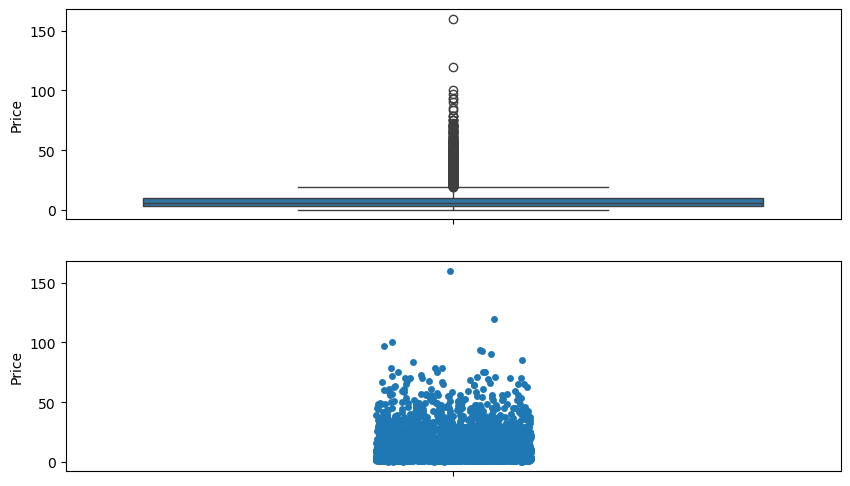

In [89]:
plt.figure(figsize=(10,6))

plt.subplot(211)
sns.boxplot(df.Price)

plt.subplot(212)
sns.stripplot(df.Price)


In [90]:
from ipywidgets import interact

# def box_strip(model):
#     sns.boxplot(data = df[df.Brand==model],
#                 x= "Brand",
#                 y= "Price",
#                 color="yellow")
    
#     sns.stripplot(data = df[df.Brand==model],
#                 x= "Brand",
#                 y= "Price",
#                 color="blue")
# brand = df["Brand"].unique()
# interact(box_strip, model=brand);

def box_strip(model):
    subset = df[df.Brand == model].copy()
    subset["Selected"] = model  # Create a constant column for plotting
    
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=subset, x="Selected", y="Price", color="yellow")
    sns.stripplot(data=subset, x="Selected", y="Price", color="blue", jitter=True, alpha=0.7)
    
    plt.title(f"Box and Strip Plot for {model}")
    plt.xlabel("Brand")
    plt.tight_layout()
    plt.show()

brand = df["Brand"].unique()
interact(box_strip, model=brand);


# This code defines the function to plot an interactive boxplot and stripplot using the ipywidgets and seaborn libraries.
# The function superimposes the boxplot and stripplot graph showing the prices of different car models covered by the data.
# The interact() function allows the box_strip function to run by selecting the user through the interface.
# This selection determines the car model that will be used to draw the graph.

interactive(children=(Dropdown(description='model', options=('Maruti', 'Hyundai', 'Honda', 'Audi', 'Nissan', '…

In [91]:
total_outliers = []

for model in df.Brand.unique():
    
    car_prices = df[df["Brand"]== model]["Price"]
    
    Q1 = car_prices.quantile(0.25)
    Q3 = car_prices.quantile(0.75)
    IQR = Q3-Q1
    lower_lim = Q1-1.5*IQR
    upper_lim = Q3+1.5*IQR
    
    count_of_outliers = car_prices[(car_prices < lower_lim) | (car_prices > upper_lim)].count()
    # Returns the total number of values that are below the lower limit and above the upper limit.
    
    rate_of_outliers = (count_of_outliers / len(df[df['Brand'] == model])).round(3)
    # We are finding the outlier rate for each Brand.
    
    total_outliers.append(count_of_outliers)
    
    print(f" The count of outliers for {model:<19} : {count_of_outliers:<2}, The rate of outliers : {rate_of_outliers}")
print() 

rate_of_total_outliers=(sum(total_outliers)/len(df)).round(3)
# The ratio of the total number of outliers for all make_models to the overall data

print(f"The Count of total outliers : {sum(total_outliers)}, The rate of total outliers : {rate_of_total_outliers}")

# According to the 1.5 wisker value, we identify the data that we consider to be outliers belonging to each group.

 The count of outliers for Maruti              : 5 , The rate of outliers : 0.004
 The count of outliers for Hyundai             : 88, The rate of outliers : 0.079
 The count of outliers for Honda               : 23, The rate of outliers : 0.038
 The count of outliers for Audi                : 5 , The rate of outliers : 0.021
 The count of outliers for Nissan              : 0 , The rate of outliers : 0.0
 The count of outliers for Toyota              : 2 , The rate of outliers : 0.005
 The count of outliers for Volkswagen          : 13, The rate of outliers : 0.041
 The count of outliers for Tata                : 10, The rate of outliers : 0.054
 The count of outliers for Land                : 2 , The rate of outliers : 0.033
 The count of outliers for Mitsubishi          : 3 , The rate of outliers : 0.111
 The count of outliers for Renault             : 4 , The rate of outliers : 0.028
 The count of outliers for Mercedes-Benz       : 11, The rate of outliers : 0.035
 The count of outl

In [92]:
def remove_outliers_brandwise(df, col='Price', group_col='Brand', threshold=1.5):
    """
    Removes outliers from a numerical column based on IQR method, grouped by a categorical column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    col (str): The name of the numerical column to check outliers for.
    group_col (str): The name of the categorical column to group by (e.g., Brand).
    threshold (float): The IQR multiplier (default is 1.5).

    Returns:
    pd.DataFrame: A DataFrame with outliers removed.
    """
    filtered_dfs = []

    for group in df[group_col].unique():
        sub_df = df[df[group_col] == group]
        Q1 = sub_df[col].quantile(0.25)
        Q3 = sub_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Keep only non-outliers for this group
        filtered = sub_df[(sub_df[col] >= lower_bound) & (sub_df[col] <= upper_bound)]
        filtered_dfs.append(filtered)

    return pd.concat(filtered_dfs, axis=0).reset_index(drop=True)

In [93]:
# df=remove_outliers_brandwise(df)

In [94]:
num_cols = ["Kilometers_Driven", "Age", "Mileage_new", "Power_new"]


def check_outliers(df, num_cols, method='IQR', threshold=2, show_plots=True):
    """
    Checks for outliers in numerical columns using the IQR method and shows boxplots.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    num_cols (list): List of numerical column names to check for outliers.
    method (str): Outlier detection method. Currently supports 'IQR'.
    threshold (float): Threshold multiplier for IQR. Default is 1.5.
    show_plots (bool): Whether to display boxplots for each column. Default is True.

    Returns:
    pd.DataFrame: Summary with count and percentage of outliers per column.
    """
    outlier_summary = []

    for col in num_cols:
        if method == 'IQR':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR

            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outlier_count = outliers.shape[0]
            outlier_pct = (outlier_count / df.shape[0]) * 100

            outlier_summary.append({
                'Column': col,
                'Outliers Count': outlier_count,
                'Outliers %': round(outlier_pct, 2),
                'Lower Bound': round(lower_bound, 2),
                'Upper Bound': round(upper_bound, 2)
            })

            if show_plots:
                plt.figure(figsize=(8, 1.5))
                sns.boxplot(x=df[col], color="skyblue", fliersize=4)
                plt.title(f"Boxplot of {col}")
                plt.xlabel(col)
                plt.tight_layout()
                plt.show()

    return pd.DataFrame(outlier_summary)


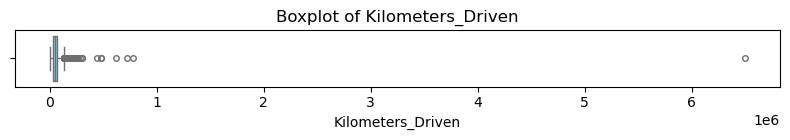

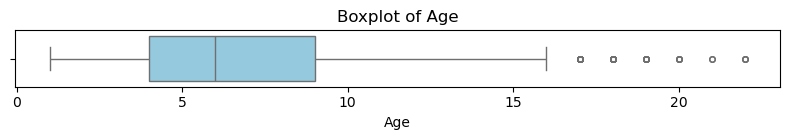

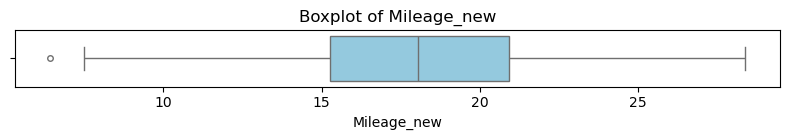

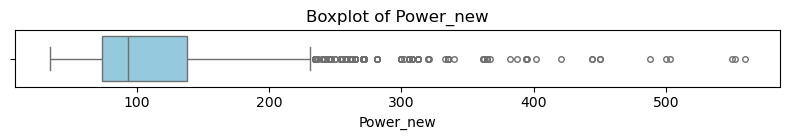

,Column,Outliers Count,Outliers %,Lower Bound,Upper Bound
0,Kilometers_Driven,110,1.83,-44000.00,151000.00
1,Age,9,0.15,-6.00,19.00
2,Mileage_new,0,0.00,3.98,32.21
3,Power_new,86,1.43,-54.20,266.30


In [95]:
check_outliers(df, num_cols)

# remove the extreme value in Kilometers_Driven

In [96]:
df.sort_values(by="Power_new", ascending=False).head(50)

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Seats,Price,Brand,Age,Mileage_new,Power_new
5781,Delhi,6500,Petrol,Automatic,Third,5204.0,2.0,120.00,Lamborghini,9,6.40,560.00
5521,Hyderabad,48000,Petrol,Automatic,First,5998.0,4.0,59.00,Bentley,14,8.60,552.00
2100,Mumbai,35000,Petrol,Automatic,Second,4806.0,5.0,32.00,Porsche,10,11.90,550.00
5088,Coimbatore,43686,Petrol,Automatic,First,5000.0,4.0,50.66,Jaguar,9,10.50,503.00
70,Mumbai,73000,Petrol,Automatic,First,4806.0,5.0,14.50,Porsche,12,8.50,500.00
5919,Hyderabad,8000,Petrol,Automatic,First,5000.0,2.0,100.00,Jaguar,5,12.50,488.10
4821,Mumbai,5900,Petrol,Automatic,First,4395.0,4.0,47.50,BMW,9,7.94,450.00
4627,Kochi,65329,Petrol,Automatic,First,4395.0,4.0,20.72,BMW,10,7.94,450.00
4061,Mumbai,23312,Petrol,Automatic,First,2894.0,4.0,40.50,Audi,7,11.05,444.00
148,Mumbai,23000,Petrol,Automatic,First,2894.0,4.0,37.00,Audi,7,11.05,444.00


### Checking for Brand categories without enough observations


In [97]:
df.Brand.value_counts()

Brand
Maruti           1207
Hyundai          1107
Honda             608
Toyota            410
Volkswagen        315
Mercedes-Benz     315
Ford              300
Mahindra          269
BMW               267
Audi              236
Tata              186
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land               60
Jaguar             40
Mitsubishi         27
Mini Cooper        26
Fiat               26
Volvo              21
Porsche            16
Jeep               15
Datsun             13
Isuzu               3
Force               3
Ambassador          1
Bentley             1
Lamborghini         1
Name: count, dtype: int64

In [98]:
# Step 1: Get brands with at least 20 occurrences
brands_to_keep = df['Brand'].value_counts()[df['Brand'].value_counts() >= 20].index

# Step 2: Filter the dataframe to keep only those brands
df = df[df['Brand'].isin(brands_to_keep)]

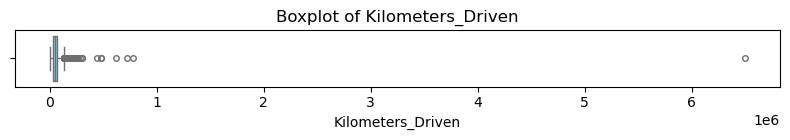

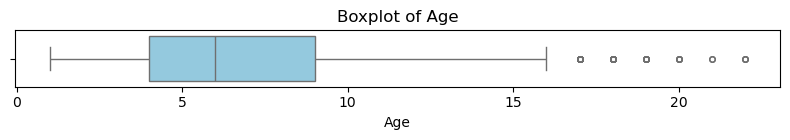

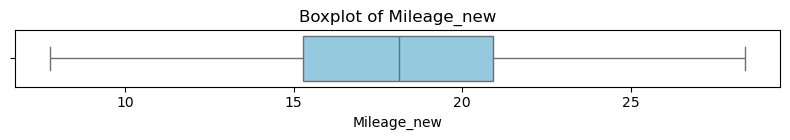

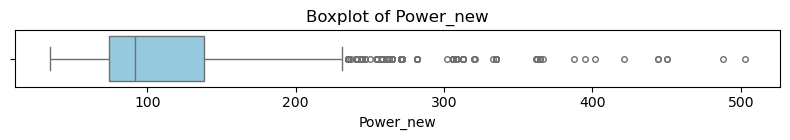

,Column,Outliers Count,Outliers %,Lower Bound,Upper Bound
0,Kilometers_Driven,110,1.85,-44000.00,151000.00
1,Age,9,0.15,-6.00,19.00
2,Mileage_new,0,0.00,4.03,32.18
3,Power_new,73,1.23,-54.06,266.09


In [99]:
# Having dropped Brands with low frequency, let's check for outliers again
check_outliers(df, num_cols)

In [100]:
df.sort_values(by="Kilometers_Driven", ascending=False).head(50)

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Seats,Price,Brand,Age,Mileage_new,Power_new
2328,Chennai,6500000,Diesel,Automatic,First,2993.0,5.0,65.00,BMW,3,15.97,258.00
340,Kolkata,775000,Diesel,Automatic,First,1968.0,5.0,7.50,Skoda,7,19.30,141.00
1860,Chennai,720000,Diesel,Manual,First,1598.0,5.0,5.90,Volkswagen,7,20.54,103.60
358,Chennai,620000,Petrol,Manual,First,1197.0,5.0,2.70,Hyundai,11,20.36,78.90
3092,Kolkata,480000,Petrol,Manual,First,1497.0,5.0,5.00,Honda,5,17.40,117.30
2823,Chennai,480000,Diesel,Automatic,First,1968.0,5.0,13.00,Volkswagen,5,16.96,138.03
4491,Bangalore,445000,Petrol,Manual,First,1197.0,5.0,4.45,Hyundai,7,18.50,82.90
3649,Jaipur,300000,Diesel,Manual,First,1405.0,5.0,1.00,Tata,12,17.00,70.00
1528,Hyderabad,299322,Diesel,Manual,First,2494.0,8.0,4.00,Toyota,15,12.80,102.00
1975,Pune,282000,Petrol,Manual,First,1798.0,5.0,3.30,Skoda,8,13.14,160.00


In [101]:
df=df[df["Kilometers_Driven"]<300000]

# log-transform 

In [102]:
df.sort_values(by="Power_new", ascending=False).head(50)
# log-transform

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Seats,Price,Brand,Age,Mileage_new,Power_new
5088,Coimbatore,43686,Petrol,Automatic,First,5000.0,4.0,50.66,Jaguar,9,10.50,503.00
5919,Hyderabad,8000,Petrol,Automatic,First,5000.0,2.0,100.00,Jaguar,5,12.50,488.10
4821,Mumbai,5900,Petrol,Automatic,First,4395.0,4.0,47.50,BMW,9,7.94,450.00
4627,Kochi,65329,Petrol,Automatic,First,4395.0,4.0,20.72,BMW,10,7.94,450.00
4061,Mumbai,23312,Petrol,Automatic,First,2894.0,4.0,40.50,Audi,7,11.05,444.00
148,Mumbai,23000,Petrol,Automatic,First,2894.0,4.0,37.00,Audi,7,11.05,444.00
4691,Bangalore,3000,Petrol,Automatic,Second,5461.0,2.0,90.00,Mercedes-Benz,6,12.00,421.00
3341,Kochi,50161,Petrol,Automatic,First,4395.0,5.0,25.93,BMW,10,8.77,402.00
4451,Kochi,21290,Petrol,Automatic,First,4951.0,4.0,56.80,Ford,2,13.00,395.00
4722,Kolkata,35000,Petrol,Automatic,First,5461.0,2.0,29.50,Mercedes-Benz,10,8.10,387.30


In [103]:
# df = df[df["Power_new"]<400]

#### Check category distributions of categorical features against small frequencies

In [104]:
df.head()

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Seats,Price,Brand,Age,Mileage_new,Power_new
0,Mumbai,72000,CNG,Manual,First,998.0,5.0,1.75,Maruti,10,15.647059,58.16
1,Pune,41000,Diesel,Manual,First,1582.0,5.0,12.50,Hyundai,5,19.670000,126.20
2,Chennai,46000,Petrol,Manual,First,1199.0,5.0,4.50,Honda,9,18.200000,88.70
3,Chennai,87000,Diesel,Manual,First,1248.0,7.0,6.00,Maruti,8,20.770000,88.76
4,Coimbatore,40670,Diesel,Automatic,Second,1968.0,5.0,17.74,Audi,7,15.200000,140.80


In [105]:
df.Location.value_counts()

Location
Mumbai        781
Hyderabad     735
Kochi         642
Coimbatore    627
Pune          617
Delhi         551
Kolkata       522
Chennai       483
Jaipur        407
Bangalore     354
Ahmedabad     223
Name: count, dtype: int64

In [106]:
df.Fuel_Type.value_counts()

Fuel_Type
Diesel    3162
Petrol    2714
CNG         56
LPG         10
Name: count, dtype: int64

In [107]:
df.Transmission.value_counts()

Transmission
Manual       4252
Automatic    1690
Name: count, dtype: int64

In [108]:
df.Owner_Type.value_counts()

Owner_Type
First             4866
Second             958
Third              109
Fourth & Above       9
Name: count, dtype: int64

In [109]:
df.Seats.value_counts()

Seats
5.0     5002
7.0      668
8.0      134
4.0       90
6.0       29
2.0       11
10.0       5
9.0        3
Name: count, dtype: int64

In [110]:
# Mean Price by Fuel_Type
mean_prices = df.groupby("Fuel_Type")["Price"].mean().sort_values(ascending=False)

# Display as a DataFrame
mean_prices = mean_prices.reset_index()
print(mean_prices)

# I will drop LPG because it's mean is quite different from that of CNG

  Fuel_Type      Price
0    Diesel  12.641230
1    Petrol   5.585943
2       CNG   3.516786
3       LPG   2.487000


In [111]:
# drop LPG
df = df[df["Fuel_Type"]!="LPG"]

In [112]:
# combine Fourth $ Above with Third into Third & Above
df["Owner_Type"] = df["Owner_Type"].replace({
    "Fourth & Above": "Third & Above",
    "Third": "Third & Above"
})
df.Owner_Type.value_counts()


Owner_Type
First            4858
Second            956
Third & Above     118
Name: count, dtype: int64

In [113]:
# Convert Seats to string and group 8.0 and above as '8+'
df["Seats"] = df["Seats"].apply(lambda x: "8+" if x >= 8 else str(int(x)))

In [114]:
df.Seats.value_counts()

Seats
5     4992
7      668
8+     142
4       90
6       29
2       11
Name: count, dtype: int64

In [115]:
# Let's drop 2 door vehicles 
df=df[df['Seats']!="2"]

In [116]:
df=df[df['Seats']!="6"]

In [117]:
df["Owner_Type"]=df["Owner_Type"].astype("category")
df["Fuel_Type"]=df["Fuel_Type"].astype("category")
df["Transmission"]=df["Transmission"].astype("category")
df["Location"]=df["Location"].astype("category")
df["Brand"]=df["Brand"].astype("category")
df["Seats"]=df["Seats"].astype("category")

In [118]:
# df.drop(columns=["Price", "Kilometers_Driven","Power_new"], inplace=True)

## Multicollinearity - VIF

In [119]:
df.select_dtypes(include="number")

,Kilometers_Driven,Engine,Price,Age,Mileage_new,Power_new
0,72000,998.0,1.75,10,15.647059,58.16
1,41000,1582.0,12.50,5,19.670000,126.20
2,46000,1199.0,4.50,9,18.200000,88.70
3,87000,1248.0,6.00,8,20.770000,88.76
4,40670,1968.0,17.74,7,15.200000,140.80
...,...,...,...,...,...,...
6014,27365,1248.0,4.75,6,28.400000,74.00
6015,100000,1120.0,4.00,5,24.400000,71.00
6016,55000,2498.0,2.90,8,14.000000,112.00
6017,46000,998.0,2.65,7,18.900000,67.10


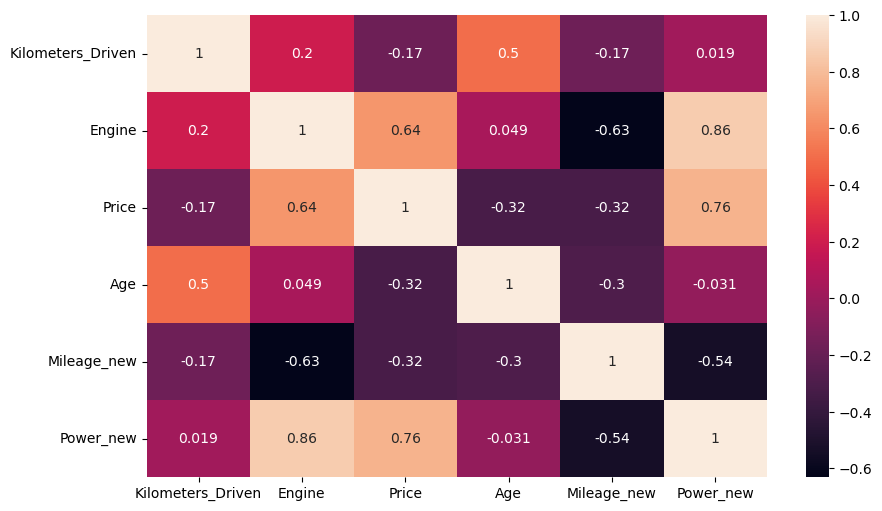

In [120]:
df_numeric = df.select_dtypes(include="number")
plt.figure(figsize=(10,6))
sns.heatmap(df_numeric.corr(), annot =True)
plt.show()

In [121]:
df_numeric.corr()[(abs(df_numeric.corr())>= 0.9) & (abs(df_numeric.corr()) < 1)].any()

Kilometers_Driven    False
Engine               False
Price                False
Age                  False
Mileage_new          False
Power_new            False
dtype: bool

In [122]:
df_numeric.corr()[(abs(df_numeric.corr())>= 0.9) & (abs(df_numeric.corr()) < 1)].any().any()

# Corr between +/-0.9 and +/-1.

np.False_

In [123]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [124]:
X_vif = df_numeric.drop(columns='Price')
X_vif.head()

,Kilometers_Driven,Engine,Age,Mileage_new,Power_new
0,72000,998.0,10,15.647059,58.16
1,41000,1582.0,5,19.670000,126.20
2,46000,1199.0,9,18.200000,88.70
3,87000,1248.0,8,20.770000,88.76
4,40670,1968.0,7,15.200000,140.80


In [125]:
df_vif = pd.DataFrame()

In [126]:
df_vif['features']=X_vif.columns

In [127]:
df_vif

,features
0,Kilometers_Driven
1,Engine
2,Age
3,Mileage_new
4,Power_new


In [128]:
X_vif.head()

,Kilometers_Driven,Engine,Age,Mileage_new,Power_new
0,72000,998.0,10,15.647059,58.16
1,41000,1582.0,5,19.670000,126.20
2,46000,1199.0,9,18.200000,88.70
3,87000,1248.0,8,20.770000,88.76
4,40670,1968.0,7,15.200000,140.80


In [129]:
variance_inflation_factor(X_vif.values, 0)


np.float64(5.901970935749715)

In [130]:
df_vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
df_vif
# check VIF scores:
# 1   -> no correlation
# 1-5 -> ok
# >5  -> Alert! Inspect further. Consider removing.
# >10 -> Severe multicolliniearity!!!

,features,VIF
0,Kilometers_Driven,5.901971
1,Engine,35.185032
2,Age,6.135721
3,Mileage_new,5.099241
4,Power_new,24.782815


In [131]:
df.drop(columns="Engine", inplace=True)

In [132]:
df.head()

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Brand,Age,Mileage_new,Power_new
0,Mumbai,72000,CNG,Manual,First,5,1.75,Maruti,10,15.647059,58.16
1,Pune,41000,Diesel,Manual,First,5,12.50,Hyundai,5,19.670000,126.20
2,Chennai,46000,Petrol,Manual,First,5,4.50,Honda,9,18.200000,88.70
3,Chennai,87000,Diesel,Manual,First,7,6.00,Maruti,8,20.770000,88.76
4,Coimbatore,40670,Diesel,Automatic,Second,5,17.74,Audi,7,15.200000,140.80


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5892 entries, 0 to 6018
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Location           5892 non-null   category
 1   Kilometers_Driven  5892 non-null   int64   
 2   Fuel_Type          5892 non-null   category
 3   Transmission       5892 non-null   category
 4   Owner_Type         5892 non-null   category
 5   Seats              5892 non-null   category
 6   Price              5892 non-null   float64 
 7   Brand              5892 non-null   category
 8   Age                5892 non-null   int64   
 9   Mileage_new        5892 non-null   float64 
 10  Power_new          5892 non-null   float64 
dtypes: category(6), float64(3), int64(2)
memory usage: 312.4 KB


In [134]:
df = df.rename(columns={"Mileage_new": "Mileage", "Power_new" : "Power"})

In [135]:
df.head()

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Brand,Age,Mileage,Power
0,Mumbai,72000,CNG,Manual,First,5,1.75,Maruti,10,15.647059,58.16
1,Pune,41000,Diesel,Manual,First,5,12.50,Hyundai,5,19.670000,126.20
2,Chennai,46000,Petrol,Manual,First,5,4.50,Honda,9,18.200000,88.70
3,Chennai,87000,Diesel,Manual,First,7,6.00,Maruti,8,20.770000,88.76
4,Coimbatore,40670,Diesel,Automatic,Second,5,17.74,Audi,7,15.200000,140.80


# LINEAR REGRESSION

In [136]:
def train_val(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    scores = {"train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : mean_squared_error(y_train, y_train_pred)**0.5,
    "mape" :mean_absolute_percentage_error(y_train, y_train_pred)},
    
    "test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : mean_squared_error(y_test, y_pred)**0.5,
    "mape" :mean_absolute_percentage_error(y_test, y_pred)}}
    
    return pd.DataFrame(scores)

In [137]:
X = df.drop(columns="Price")
y=df.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [138]:
X_train.head()

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Brand,Age,Mileage,Power
707,Pune,120000,Diesel,Automatic,First,5,Mercedes-Benz,6,15.26,165.00
4595,Coimbatore,42366,Diesel,Automatic,First,5,Audi,3,15.73,174.33
2626,Kolkata,38001,Petrol,Automatic,First,5,Audi,10,12.30,163.20
196,Jaipur,43571,Petrol,Manual,First,5,Hyundai,5,20.36,78.90
295,Hyderabad,74000,Petrol,Manual,First,5,Hyundai,10,20.36,78.90


In [139]:
X_train.Owner_Type.value_counts()

Owner_Type
First            3871
Second            746
Third & Above      96
Name: count, dtype: int64

In [140]:
X_train.Seats.value_counts()

Seats
5     3990
7      530
8+     116
4       77
Name: count, dtype: int64

In [141]:
cat_onehot = ["Location", "Fuel_Type", "Owner_Type", "Seats", "Transmission", "Brand"]

In [142]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV


enc_onehot = OneHotEncoder(drop='first', handle_unknown="ignore", sparse_output=False)


column_trans = make_column_transformer((enc_onehot, cat_onehot),
                                        remainder='passthrough',
                                        verbose_feature_names_out=False) # MinMaxScaler()

In [143]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

In [144]:
alpha_space = np.linspace(0.001, 100, 100)

In [145]:
from sklearn.base import BaseEstimator, TransformerMixin

class Log1pTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, log1p_cols=None):
        self.log1p_cols = log1p_cols

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in self.log1p_cols:
            X[col] = np.log1p(X[col])
        return X

log1p_cols = ["Power", "Kilometers_Driven"]

In [146]:
from sklearn.compose import TransformedTargetRegressor

ridge_model = TransformedTargetRegressor(
    regressor=Ridge(),
    func=np.log,
    inverse_func=np.exp
)

operations = [
    ("log1p", Log1pTransformer(log1p_cols=log1p_cols)),
    ("OneHot_Ordinal_Encoder", column_trans), 
    ("scaler", MinMaxScaler()), 
    ("Ridge", ridge_model)  # this already includes log(y)
]

pipe_model = Pipeline(steps=operations)


param_grid = {'Ridge__regressor__alpha':alpha_space}  # # Parameter names should be used together with the model name defined
                                           # in the pipeline..

ridge_grid_model = GridSearchCV(estimator=pipe_model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=10,
                          n_jobs = -1,
                          return_train_score=True)

In [147]:
ridge_grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('log1p',
                                        Log1pTransformer(log1p_cols=['Power',
                                                                     'Kilometers_Driven'])),
                                       ('OneHot_Ordinal_Encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Location',
                                                                          'Fuel_Type',
                                                                          'Owner_Type',
                                                                          'Seats',
                                                                          'Transmission',
                                                                          'Bran...
       8.08082727e+01, 8.18183636e+01, 8.28284545e+01, 8.38385455e+01,
       8.48486364e+01, 8.58587273e+01, 8.68688182e+01, 8.78789091e+01,
       8.88890000e+01, 8.98990909e+01, 9.09091818e+01, 9.19192727e+01,
       9.29293636e+01, 9.39394545e+01, 9.49495455e+01, 9.59596364e+01,
       9.69697273e+01, 9.79798182e+01, 9.89899091e+01, 1.00000000e+02])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [148]:
ridge_grid_model.best_estimator_["Ridge"]

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Ridge(alpha=np.float64(0.001)))

In [149]:
ridge_grid_model.best_params_

{'Ridge__regressor__alpha': np.float64(0.001)}

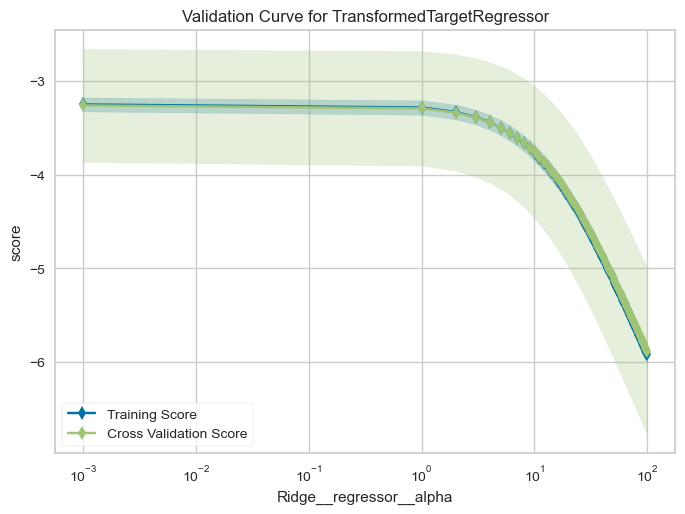

In [150]:
from yellowbrick.model_selection import ValidationCurve
viz = ValidationCurve(
                      pipe_model, 
                      param_name="Ridge__regressor__alpha", 
                      param_range=np.linspace(0.001, 100, 100),
                      logx=True, 
                      cv=10, 
                      scoring="neg_root_mean_squared_error",
                      n_jobs=-1
)

viz.fit(X_train, y_train)
viz.show();

In [151]:
pd.DataFrame(ridge_grid_model.cv_results_).loc[ridge_grid_model.best_index_, ["mean_test_score", "mean_train_score"]]
# in the pipeline, we focused on negative root mean squared error as our goodness of fit metric.
# We searched for the alpha value that would minimize negative root mean squared error.

mean_test_score    -3.260718
mean_train_score    -3.25046
Name: 0, dtype: object

In [152]:
train_val(ridge_grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.903709,0.903564
mae,1.498689,1.656907
mse,10.594554,11.860307
rmse,3.254928,3.443880
mape,0.164778,0.176619


In [153]:
y_pred = ridge_grid_model.predict(X_test)
rm_R2 = r2_score(y_test, y_pred)
rm_mae = mean_absolute_error(y_test, y_pred)
rm_rmse = mean_squared_error(y_test, y_pred)**0.5
rm_mape= mean_absolute_percentage_error(y_test, y_pred)

In [154]:
# pd.DataFrame(data= ridge_grid_model.best_estimator_["Ridge"].coef_, 
#              index=ridge_grid_model.best_estimator_["OneHot_Ordinal_Encoder"].get_feature_names_out(), 
#              columns=["Coef"]).sort_values("Coef")


coefs = pd.DataFrame(
    data=ridge_grid_model.best_estimator_["Ridge"].regressor_.coef_, 
    index=ridge_grid_model.best_estimator_["OneHot_Ordinal_Encoder"].get_feature_names_out(), 
    columns=["Coef"]
).sort_values("Coef")

coefs

,Coef
Age,-2.371433
Brand_Tata,-1.028946
Brand_Chevrolet,-0.946053
Brand_Fiat,-0.851367
Brand_Mahindra,-0.766890
Brand_Ford,-0.645158
Brand_Renault,-0.640133
Brand_Volkswagen,-0.616321
Brand_Honda,-0.614346
Brand_Hyundai,-0.610227


## Lasso

In [155]:
from sklearn.linear_model import Lasso

In [156]:
from sklearn.compose import TransformedTargetRegressor

lasso_model = TransformedTargetRegressor(
    regressor=Lasso(),
    func=np.log,
    inverse_func=np.exp
)

operations = [
    ("log1p", Log1pTransformer(log1p_cols=log1p_cols)),
    ("OneHot_Ordinal_Encoder", column_trans), 
    ("scaler", MinMaxScaler()), 
    ("Lasso", lasso_model)  # this already includes log(y)
]

pipe_model = Pipeline(steps=operations)


param_grid = {'Lasso__regressor__alpha':alpha_space}  # # Parameter names should be used together with the model name defined
                                           # in the pipeline.. alpha_space = [0.1, 1, 10, 50, 100, 500, 1000] 

lasso_grid_model = GridSearchCV(estimator=pipe_model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=10,
                          n_jobs = -1,
                          return_train_score=True)

In [157]:
lasso_grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('log1p',
                                        Log1pTransformer(log1p_cols=['Power',
                                                                     'Kilometers_Driven'])),
                                       ('OneHot_Ordinal_Encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Location',
                                                                          'Fuel_Type',
                                                                          'Owner_Type',
                                                                          'Seats',
                                                                          'Transmission',
                                                                          'Bran...
       8.08082727e+01, 8.18183636e+01, 8.28284545e+01, 8.38385455e+01,
       8.48486364e+01, 8.58587273e+01, 8.68688182e+01, 8.78789091e+01,
       8.88890000e+01, 8.98990909e+01, 9.09091818e+01, 9.19192727e+01,
       9.29293636e+01, 9.39394545e+01, 9.49495455e+01, 9.59596364e+01,
       9.69697273e+01, 9.79798182e+01, 9.89899091e+01, 1.00000000e+02])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [158]:
lasso_grid_model.best_estimator_["Lasso"]

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Lasso(alpha=np.float64(0.001)))

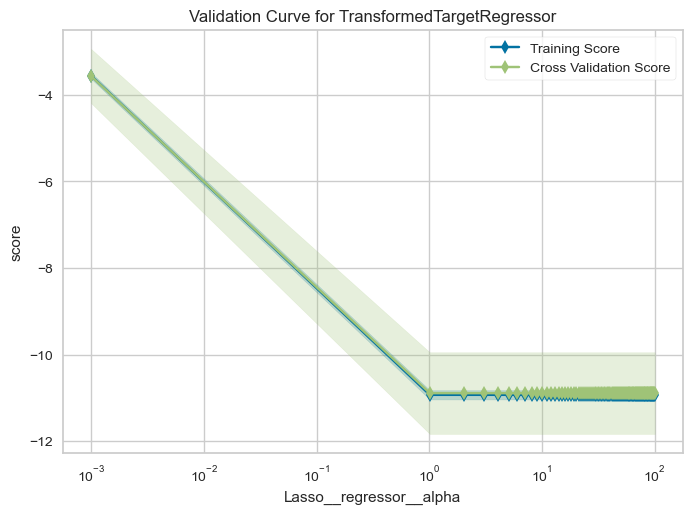

In [159]:
from yellowbrick.model_selection import ValidationCurve
viz = ValidationCurve(
                      pipe_model, 
                      param_name="Lasso__regressor__alpha", 
                      param_range= alpha_space,     #np.linspace(0.001, 100, 100),
                      logx=True, 
                      cv=10, 
                      scoring="neg_root_mean_squared_error",
                      n_jobs=-1
)

viz.fit(X_train, y_train)
viz.show();

In [160]:
pd.DataFrame(lasso_grid_model.cv_results_).loc[lasso_grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

# mean test score refers to validation scores in cross validation
# mean train score is from the train set

mean_test_score    -3.568323
mean_train_score   -3.559183
Name: 0, dtype: object

In [161]:
train_val(lasso_grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.884546,0.889533
mae,1.608765,1.721348
mse,12.702885,13.585914
rmse,3.564111,3.685907
mape,0.172988,0.181564


In [162]:
y_pred = lasso_grid_model.predict(X_test)
lasm_R2 = r2_score(y_test, y_pred)
lasm_mae = mean_absolute_error(y_test, y_pred)
lasm_rmse = mean_squared_error(y_test, y_pred)**0.5
lasm_mape= mean_absolute_percentage_error(y_test, y_pred)

In [163]:
# pd.DataFrame(data=lasso_grid_model.best_estimator_["Lasso"].coef_, 
#              index=lasso_grid_model.best_estimator_["OneHot_Ordinal_Encoder"].get_feature_names_out(), 
#              columns=["Coef"]).sort_values("Coef")


coefs = pd.DataFrame(
    data=lasso_grid_model.best_estimator_["Lasso"].regressor_.coef_, 
    index=lasso_grid_model.best_estimator_["OneHot_Ordinal_Encoder"].get_feature_names_out(), 
    columns=["Coef"]
).sort_values("Coef")

coefs

,Coef
Age,-2.310013
Brand_Tata,-0.633500
Brand_Chevrolet,-0.555140
Kilometers_Driven,-0.483453
Brand_Mahindra,-0.387378
Brand_Fiat,-0.316880
Brand_Honda,-0.287174
Brand_Ford,-0.284139
Brand_Volkswagen,-0.267164
Brand_Hyundai,-0.263597


### Elastic-Net

In [164]:
from sklearn.linear_model import ElasticNet

In [165]:
from sklearn.compose import TransformedTargetRegressor

elastic_model = ElasticNet()

# The target transformation (log transformation on y)
target_transformer = TransformedTargetRegressor(
    regressor=elastic_model,
    func=np.log,  # Log transformation on the target variable (y)
    inverse_func=np.exp  # Inverse transformation after prediction (exp)
)

operations = [
    ("log1p", Log1pTransformer(log1p_cols=log1p_cols)),  # Apply log1p to specified columns
    ("OneHot_Ordinal_Encoder", column_trans),  # OneHotEncoding for categorical features
    ("scaler", MinMaxScaler()),  # MinMax scaling for numeric features
    ("ElasticNet", target_transformer)  # ElasticNet wrapped in TransformedTargetRegressor
]

pipe_model = Pipeline(steps=operations)


param_grid = {
    'ElasticNet__regressor__alpha': [0.001, 0.1, 1, 10, 100],  # Regularization strength for ElasticNet
    'ElasticNet__regressor__l1_ratio': [0.1, 0.5, 0.9, 1]  # Proportion of L1 regularization in ElasticNet
}

# Set up GridSearchCV
elastic_grid_model = GridSearchCV(
    estimator=pipe_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1,
    return_train_score=True
)


In [166]:
elastic_grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('log1p',
                                        Log1pTransformer(log1p_cols=['Power',
                                                                     'Kilometers_Driven'])),
                                       ('OneHot_Ordinal_Encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Location',
                                                                          'Fuel_Type',
                                                                          'Owner_Type',
                                                                          'Seats',
                                                                          'Transmission',
                                                                          'Bran...
                                                          verbose_feature_names_out=False)),
                                       ('scaler', MinMaxScaler()),
                                       ('ElasticNet',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=ElasticNet()))]),
             n_jobs=-1,
             param_grid={'ElasticNet__regressor__alpha': [0.001, 0.1, 1, 10,
                                                          100],
                         'ElasticNet__regressor__l1_ratio': [0.1, 0.5, 0.9, 1]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [167]:
elastic_grid_model.best_estimator_

Pipeline(steps=[('log1p',
                 Log1pTransformer(log1p_cols=['Power', 'Kilometers_Driven'])),
                ('OneHot_Ordinal_Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Location', 'Fuel_Type',
                                                   'Owner_Type', 'Seats',
                                                   'Transmission', 'Brand'])],
                                   verbose_feature_names_out=False)),
                ('scaler', MinMaxScaler()),
                ('ElasticNet',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=ElasticNet(alpha=0.001,
                                                                 l1_ratio=0.1)))])

In [168]:
pd.DataFrame(elastic_grid_model.cv_results_).loc[elastic_grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

mean_test_score    -3.461881
mean_train_score   -3.458342
Name: 0, dtype: object

In [169]:
train_val(elastic_grid_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.890940,0.896360
mae,1.565237,1.693803
mse,11.999478,12.746259
rmse,3.464026,3.570190
mape,0.169100,0.178561


In [170]:
y_pred = elastic_grid_model.predict(X_test)
em_R2 = r2_score(y_test, y_pred)
em_mae = mean_absolute_error(y_test, y_pred)
em_rmse = mean_squared_error(y_test, y_pred)**0.5
em_mape= mean_absolute_percentage_error(y_test, y_pred)

# Visually Compare Model Performances in Graphs

In [171]:
compare = pd.DataFrame({"Model": ["ridge_m", "lasso_m", "elastic_m"],
                        "r2_score": [rm_R2, lasm_R2, em_R2],
                        "mae": [rm_mae, lasm_mae, em_mae],
                        "rmse": [rm_rmse, lasm_rmse, em_rmse],
                        "mape": [rm_mape, lasm_mape, em_mape]})
compare

# We assign the metrics we get from all estimated models to the scores variable in dict format.

,Model,r2_score,mae,rmse,mape
0,ridge_m,0.903564,1.656907,3.443880,0.176619
1,lasso_m,0.889533,1.721348,3.685907,0.181564
2,elastic_m,0.896360,1.693803,3.570190,0.178561


In [172]:
compare.sort_values(by="r2_score", ascending=False) #  ascending=False sorts in descending (high-->low) order.

,Model,r2_score,mae,rmse,mape
0,ridge_m,0.903564,1.656907,3.443880,0.176619
2,elastic_m,0.896360,1.693803,3.570190,0.178561
1,lasso_m,0.889533,1.721348,3.685907,0.181564


In [173]:
compare.sort_values(by="mae", ascending=True) #  ascending=True sorts in ascending (low-->high) order.

,Model,r2_score,mae,rmse,mape
0,ridge_m,0.903564,1.656907,3.443880,0.176619
2,elastic_m,0.896360,1.693803,3.570190,0.178561
1,lasso_m,0.889533,1.721348,3.685907,0.181564


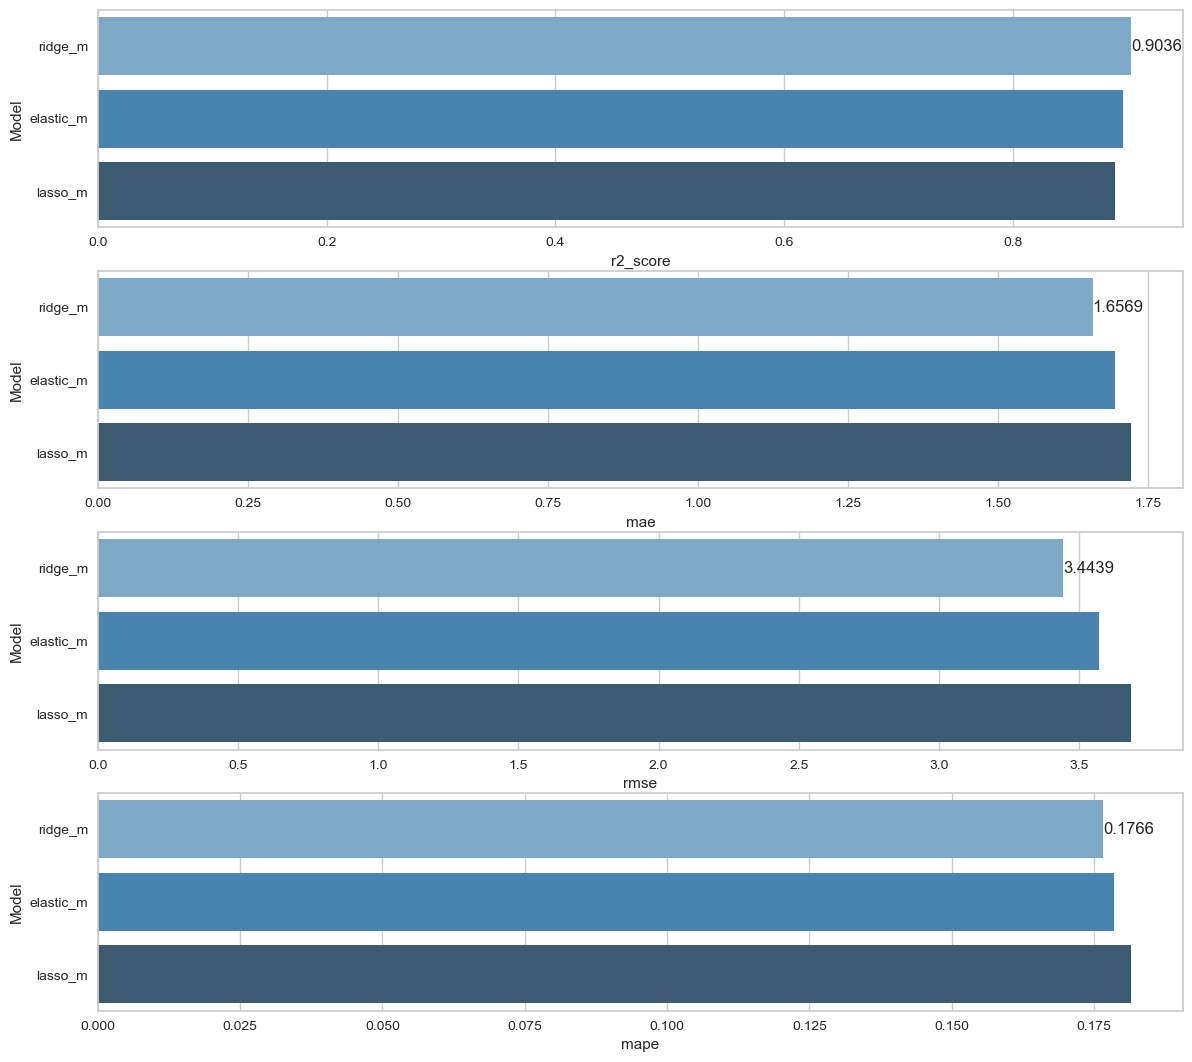

In [174]:
plt.figure(figsize=(14,13))

plt.subplot(411)
compare = compare.sort_values(by="r2_score", ascending=False)
ax=sns.barplot(x="r2_score", y="Model", data=compare, palette="Blues_d")
ax.bar_label(ax.containers[0],fmt="%.4f")

plt.subplot(412)
compare = compare.sort_values(by="mae", ascending=True)
ax=sns.barplot(x="mae", y="Model", data=compare, palette="Blues_d")
ax.bar_label(ax.containers[0],fmt="%.4f")

plt.subplot(413)
compare = compare.sort_values(by="rmse", ascending=True)
ax=sns.barplot(x="rmse", y="Model", data=compare, palette="Blues_d")
ax.bar_label(ax.containers[0],fmt="%.4f")

plt.subplot(414)
compare = compare.sort_values(by="mape", ascending=True)
ax=sns.barplot(x="mape", y="Model", data=compare, palette="Blues_d")
ax.bar_label(ax.containers[0],fmt="%.4f")
plt.show()

# Final Model and Prediction with New Observations

In [175]:
df

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Brand,Age,Mileage,Power
0,Mumbai,72000,CNG,Manual,First,5,1.75,Maruti,10,15.647059,58.16
1,Pune,41000,Diesel,Manual,First,5,12.50,Hyundai,5,19.670000,126.20
2,Chennai,46000,Petrol,Manual,First,5,4.50,Honda,9,18.200000,88.70
3,Chennai,87000,Diesel,Manual,First,7,6.00,Maruti,8,20.770000,88.76
4,Coimbatore,40670,Diesel,Automatic,Second,5,17.74,Audi,7,15.200000,140.80
...,...,...,...,...,...,...,...,...,...,...,...
6014,Delhi,27365,Diesel,Manual,First,5,4.75,Maruti,6,28.400000,74.00
6015,Jaipur,100000,Diesel,Manual,First,5,4.00,Hyundai,5,24.400000,71.00
6016,Jaipur,55000,Diesel,Manual,Second,8+,2.90,Mahindra,8,14.000000,112.00
6017,Kolkata,46000,Petrol,Manual,First,5,2.65,Maruti,7,18.900000,67.10


In [176]:
X = df.drop(columns="Price")
y = df.Price

In [177]:
X.head()

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Brand,Age,Mileage,Power
0,Mumbai,72000,CNG,Manual,First,5,Maruti,10,15.647059,58.16
1,Pune,41000,Diesel,Manual,First,5,Hyundai,5,19.670000,126.20
2,Chennai,46000,Petrol,Manual,First,5,Honda,9,18.200000,88.70
3,Chennai,87000,Diesel,Manual,First,7,Maruti,8,20.770000,88.76
4,Coimbatore,40670,Diesel,Automatic,Second,5,Audi,7,15.200000,140.80


In [178]:




operations = [("OneHot_Ordinal_Encoder", column_trans), 
              ("scaler", MinMaxScaler()), 
              ("Ridge", Ridge())]

final_model = Pipeline(steps=operations)


In [179]:
final_model.fit(X, y)

Pipeline(steps=[('OneHot_Ordinal_Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Location', 'Fuel_Type',
                                                   'Owner_Type', 'Seats',
                                                   'Transmission', 'Brand'])],
                                   verbose_feature_names_out=False)),
                ('scaler', MinMaxScaler()), ('Ridge', Ridge())])

In [180]:
X

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Brand,Age,Mileage,Power
0,Mumbai,72000,CNG,Manual,First,5,Maruti,10,15.647059,58.16
1,Pune,41000,Diesel,Manual,First,5,Hyundai,5,19.670000,126.20
2,Chennai,46000,Petrol,Manual,First,5,Honda,9,18.200000,88.70
3,Chennai,87000,Diesel,Manual,First,7,Maruti,8,20.770000,88.76
4,Coimbatore,40670,Diesel,Automatic,Second,5,Audi,7,15.200000,140.80
...,...,...,...,...,...,...,...,...,...,...
6014,Delhi,27365,Diesel,Manual,First,5,Maruti,6,28.400000,74.00
6015,Jaipur,100000,Diesel,Manual,First,5,Hyundai,5,24.400000,71.00
6016,Jaipur,55000,Diesel,Manual,Second,8+,Mahindra,8,14.000000,112.00
6017,Kolkata,46000,Petrol,Manual,First,5,Maruti,7,18.900000,67.10


In [181]:
ridge_model = TransformedTargetRegressor(
    regressor=Ridge(alpha=0.001),
    func=np.log,
    inverse_func=np.exp
)

operations = [
    ("log1p", Log1pTransformer(log1p_cols=log1p_cols)),
    ("OneHot_Ordinal_Encoder", column_trans), 
    ("scaler", MinMaxScaler()), 
    ("Ridge", ridge_model)  # this already includes log(y)
]

final_model = Pipeline(steps=operations)

In [182]:
final_model.fit(X,y)

Pipeline(steps=[('log1p',
                 Log1pTransformer(log1p_cols=['Power', 'Kilometers_Driven'])),
                ('OneHot_Ordinal_Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Location', 'Fuel_Type',
                                                   'Owner_Type', 'Seats',
                                                   'Transmission', 'Brand'])],
                                   verbose_feature_names_out=False)),
                ('scaler', MinMaxScaler()),
                ('Ridge',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge(alpha=0.001)))])

In [183]:
df.Location.unique()

['Mumbai', 'Pune', 'Chennai', 'Coimbatore', 'Jaipur', ..., 'Kolkata', 'Delhi', 'Bangalore', 'Hyderabad', 'Ahmedabad']
Length: 11
Categories (11, object): ['Ahmedabad', 'Bangalore', 'Chennai', 'Coimbatore', ..., 'Kochi', 'Kolkata', 'Mumbai', 'Pune']

In [184]:
df.Transmission.unique()

['Manual', 'Automatic']
Categories (2, object): ['Automatic', 'Manual']

In [185]:
X.head(1)

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Brand,Age,Mileage,Power
0,Mumbai,72000,CNG,Manual,First,5,Maruti,10,15.647059,58.16


In [186]:
my_dict= {
    "Location" : "Mumbai",
    "Kilometers_Driven": 72000,
    "Fuel_Type" : "CNG",
    "Transmission" : "Manual",
    "Owner_Type" : "First",
    "Seats" : "5",
    "Brand" : "Maruti",
    "Age" : 10,
    "Mileage" : 15.65,
    "Power" : 58.16 
    }

In [187]:
new_obs = pd.DataFrame([my_dict])
new_obs

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Brand,Age,Mileage,Power
0,Mumbai,72000,CNG,Manual,First,5,Maruti,10,15.65,58.16


In [188]:
final_model.predict(new_obs)

array([1.84545489])

In [189]:
y.head(1)

0    1.75
Name: Price, dtype: float64

In [190]:
new_obs = X.iloc[[3]]

In [191]:
final_model.predict(new_obs)

array([5.43954455])

In [192]:
y.iloc[3]

np.float64(6.0)